<a href="https://colab.research.google.com/github/thenazar9/ecommerce-sales-analysis/blob/main/Comprehensive_E_commerce_Sales_Data_Analysis_From_Raw_Data_to_Actionable_Insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Comprehensive E-commerce Sales Data Analysis: From Raw Data to Actionable Insights**

## Project Overview

In this project, I performed a comprehensive analysis of sales data using **Python**, **SQL**, and **Tableau**. The project focuses on exploring sales trends, analyzing product performance, examining user behaviors, and performing statistical tests to uncover insights for business strategy. The data was extracted using **SQL** queries, analyzed and processed using **Python** libraries, and visualized through an **Analytical Dashboard** in **Tableau**.

### Table of Contents

- **Library Installation, Import, and Data Extraction**
- **Dataset Overview**
- **Comprehensive Sales Analysis and Trends**
  - **General Sales Analysis**
    1. Total Sales and Units Sold by Continent
    2. Top 5 Countries by Total Sales and Units Sold
    3. Top 10 Product Categories by Total Sales and Units Sold
    4. Top Product Categories in the Top-Selling Country
  - **In-Depth Sales Analysis**
    1. Sales Distribution by Traffic Channels and Device Types (as % of Total Sales)
    2. Visualization and Analysis of Email Verification and Subscription Status
  - **Sales Dynamics Analysis**
    1. Overall sales dynamics
    2. Sales Dynamics by Day of the Week
    3. Sales Dynamics by Continents
    4. Sales Dynamics by Device Type
    5. Sales Dynamics by Traffic Channel
- **Pivot Tables**
  1. Session Count by Traffic Channels and Device Types
  2. Total Sales by Product Categories (Top 10) in Top 5 Countries
  3. Average Sales by Product Categories and Device Types
  4. Session Count by Top 10 Countries and Operating System Types
- **Statistical Analysis**
  1. Daily Relationship Between Sessions and Sales
  2. Sales Correlation Between the Top 3 Continents
  3. Correlation Between Sales from Different Traffic Channels
  4. Correlation Between Sales of the Top 5 Product Categories
- **Statistical Tests**
  1. Testing for a statistically significant difference in sales between registered and unregistered users.
  2. Testing for differences in the number of sessions across traffic channels.
  3. Testing for differences in the share of organic traffic between Europe and America.
  4. Testing for a statistically significant difference in average sales price between different continents.
- **Analytical Dashboard in Tableau Public**


## Library Installation, Import, and Data Extraction

In [ ]:
# Install required libraries
!pip install --upgrade google-cloud-bigquery
print()
!pip install scikit-posthocs

In [ ]:
# Auth & BigQuery
from google.colab import auth
from google.cloud import bigquery

# Data & Analysis
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, shapiro, mannwhitneyu, kruskal
import scikit_posthocs as sp

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

In [ ]:
auth.authenticate_user()

In [ ]:
client = bigquery.Client(project="data-analytics-mate")

In [ ]:
query = """
WITH
  session_info AS (
  SELECT
    s.date,
    s.ga_session_id,
    sp.continent,
    sp.country,
    sp.device,
    sp.browser,
    sp.mobile_model_name,
    sp.operating_system,
    sp.language,
    sp.medium,
    sp.channel
  FROM
    `data-analytics-mate.DA.session` s
  LEFT JOIN
    `data-analytics-mate.DA.session_params` sp
  ON
    s.ga_session_id = sp.ga_session_id ),
  account_info AS (
  SELECT
    acs.ga_session_id,
    ac.id AS user_id,
    CASE
      WHEN ac.is_verified = 1 THEN TRUE
      ELSE FALSE
  END
    AS is_verified,
    CASE
      WHEN ac.is_unsubscribed = 0 THEN TRUE
      ELSE FALSE
  END
    AS is_unsubscribed
  FROM
    `data-analytics-mate.DA.account_session` acs
  LEFT JOIN
    `data-analytics-mate.DA.account` ac
  ON
    acs.account_id = ac.id ),
  product_info AS (
  SELECT
    o.ga_session_id,
    p.category,
    p.name,
    p.price,
    p.short_description
  FROM
    `data-analytics-mate.DA.order` o
  LEFT JOIN
    `data-analytics-mate.DA.product` p
  ON
    o.item_id = p.item_id )
SELECT
  si.date AS order_date,
  si.ga_session_id,
  si.continent,
  si.country,
  si.device,
  si.browser,
  si.mobile_model_name,
  si.operating_system,
  si.language,
  si.medium AS traffic_source,
  si.channel AS traffic_channel,
  ai.user_id,
  ai.is_verified AS is_email_verified,
  ai.is_unsubscribed,
  pi.category,
  pi.name AS product_name,
  pi.price,
  pi.short_description
FROM
  session_info si
LEFT JOIN
  account_info ai
ON
  si.ga_session_id = ai.ga_session_id
LEFT JOIN
  product_info pi
ON
  si.ga_session_id = pi.ga_session_id
"""

In [ ]:
query_job = client.query(query)
results = query_job.result()

In [ ]:
df = results.to_dataframe()

In [ ]:
df.head()

,order_date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,traffic_source,traffic_channel,user_id,is_email_verified,is_unsubscribed,category,product_name,price,short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,zh,<Other>,Paid Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,en-us,organic,Organic Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,zh,(none),Direct,<NA>,<NA>,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,es-es,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,en-us,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


##Dataset Overview

In [ ]:
# Get the number of rows and columns
df.shape

(349545, 18)

In [ ]:
# General info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   traffic_source     349545 non-null  object 
 10  traffic_channel    349545 non-null  object 
 11  user_id            27945 non-null   Int64  
 12  is_email_verified  27945 non-null   boolean
 13  is_unsubscribed    27945 non-null   boolean
 14  category           33538 non-null   object 
 15  product_name       33538 non-null   object 
 16  pr

In [ ]:
# Convert the 'order_date' column to datetime format
df['order_date'] = pd.to_datetime(df['order_date'])

In [ ]:
# Check data types of all columns
df.dtypes

,0
order_date,datetime64[ns]
ga_session_id,Int64
continent,object
country,object
device,object
browser,object
mobile_model_name,object
operating_system,object
language,object
traffic_source,object


In [ ]:
# Generate descriptive statistics for numeric columns
df.describe()

,order_date,ga_session_id,user_id,price
count,349545,349545.0,27945.0,33538.000000
mean,2020-12-16 12:42:00.602497536,4992250296.631739,659005.065557,953.298679
min,2020-11-01 00:00:00,1205.0,636133.0,3.000000
25%,2020-11-26 00:00:00,2493646855.0,647576.0,170.000000
50%,2020-12-15 00:00:00,4988476074.0,658952.0,445.000000
75%,2021-01-08 00:00:00,7491286508.0,670414.0,1195.000000
max,2021-01-31 00:00:00,9999997129.0,681962.0,9585.000000
std,NaN,2887450949.537772,13216.529465,1317.001775


In [ ]:
# Count the number of unique sessions
print("Number of unique sessions:", df["ga_session_id"].nunique())
# Check the date range of the dataset
print("Period: from", df["order_date"].min(), "to", df["order_date"].max())

Number of unique sessions: 349545
Period: from 2020-11-01 00:00:00 to 2021-01-31 00:00:00


In [ ]:
# Count missing values in each column
df.isna().sum(axis=0)

,0
order_date,0
ga_session_id,0
continent,0
country,0
device,0
browser,0
mobile_model_name,0
operating_system,0
language,114266
traffic_source,0


In [ ]:
# Show the ratio of missing values for each column (as a percentage of total rows)
df.isna().sum() / df.shape[0]

,0
order_date,0.000000
ga_session_id,0.000000
continent,0.000000
country,0.000000
device,0.000000
browser,0.000000
mobile_model_name,0.000000
operating_system,0.000000
language,0.326899
traffic_source,0.000000


The dataset contains 349,545 rows and 18 columns.

There are 3 numerical columns:
- `ga_session_id` and `user_id` are integer types (Int64),
- `price` is a floating-point number (float64).

There are 12 categorical (object) columns:
- `continent`, `country`, `device`, `browser`, `mobile_model_name`, `operating_system`, `language`, `traffic_source`, `traffic_channel`, `category`, `product_name`, `short_description`.

There is 1 datetime column:
- `order_date` was converted using `pd.to_datetime()` to ensure proper datetime format.

There are 2 boolean columns:
- `is_email_verified`, `is_unsubscribed`.

The number of unique sessions (`ga_session_id`) is 349,545, which means each session is unique.

The dataset covers a 3-month period from 2020-11-01 to 2021-01-31.

Missing values are present in several columns:
- `language` is missing in 32.7% of rows — this could be due to missing or unavailable browser settings.
- `user_id`, `is_email_verified`, and `is_unsubscribed` are missing in 92% — this likely indicates that these sessions belong to users who did not register an account.
- `category`, `product_name`, `price`, and `short_description` are missing in 90.4% — this suggests that many sessions did not result in a product purchase.


## Comprehensive Sales Analysis and Trends

### General Sales Analysis

**Total Sales and Units Sold by Continent**

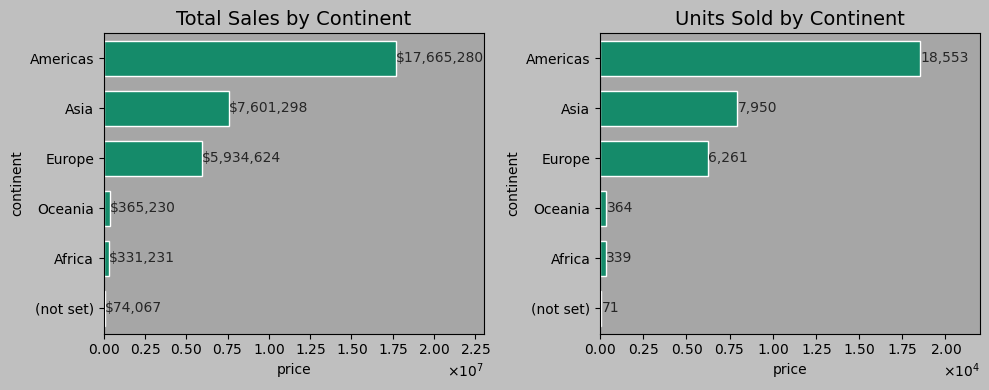

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

plt.gcf().set_facecolor("#bfbfbf")

for axes in ax.flat:
    axes.set_facecolor("#a6a6a6")

sns.set_style("whitegrid")

colors_colorblind = sns.color_palette("colorblind")

# using MaxNLocator to automatically display numbers in scientific notation for all graphs
for axis in ax.flat:
    axis.xaxis.set_major_locator(ticker.MaxNLocator())
    axis.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# [0] Total Sales by Continent
continent_sales = df.groupby("continent")["price"].sum().reset_index().sort_values(by="price", ascending=False)

sns.barplot(data=continent_sales, x="price", y="continent", ax=ax[0], color=colors_colorblind[2], errorbar=("ci", False), width=0.7)
ax[0].set_title("Total Sales by Continent", fontsize=14, fontweight = "medium")
ax[0].set_xlim(0, 0.23e8)

for bar in ax[0].patches:
    ax[0].text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"${int(bar.get_width()):,}",
        ha="left",
        va="center"
    )

# [1] Units Sold by Continent
continent_units_sold = df.groupby("continent")["price"].count().reset_index().sort_values(by="price", ascending=False)

sns.barplot(data=continent_units_sold, x="price", y="continent", ax=ax[1], color=colors_colorblind[2], errorbar=("ci", False), width=0.7)
ax[1].set_title("Units Sold by Continent", fontsize=14, fontweight = "medium")
ax[1].set_xlim(0, 22000)

for bar in ax[1].patches:
    ax[1].text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"{int(bar.get_width()):,}",
        ha="left",
        va="center"
    )

plt.tight_layout()
plt.show()

The American continent stands out as the clear leader in sales volume, generating the highest sales and selling the largest number of units. Asia and Europe follow as the next largest markets, although their figures are considerably lower than those of the Americas. Africa and Oceania currently demonstrate very modest sales results.

**Top 5 Countries by Total Sales and Units Sold**

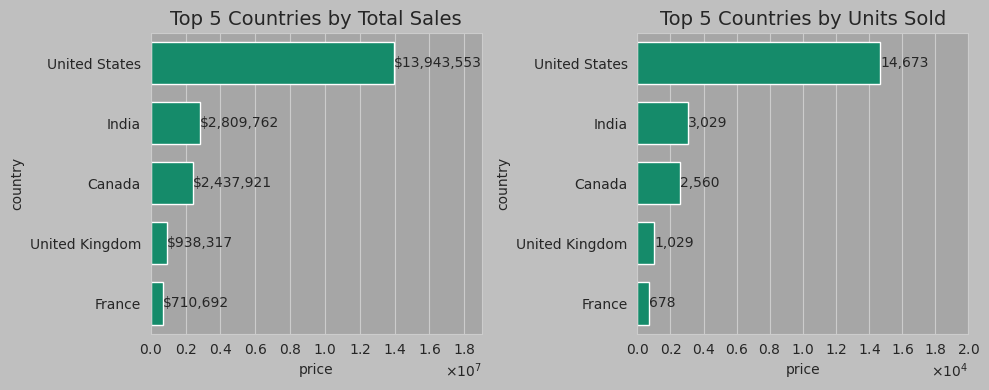

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

plt.gcf().set_facecolor("#bfbfbf")

for axes in ax.flat:
    axes.set_facecolor("#a6a6a6")

sns.set_style("whitegrid")

colors_colorblind = sns.color_palette("colorblind")

# using MaxNLocator to automatically display numbers in scientific notation for all graphs
for axis in ax.flat:
    axis.xaxis.set_major_locator(ticker.MaxNLocator())
    axis.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# [0] Top 5 Countries by Total Sales
country_sales = df.groupby("country")["price"].sum().reset_index().sort_values(by="price", ascending=False).nlargest(5, "price")

sns.barplot(data=country_sales, x="price", y="country", ax=ax[0], color=colors_colorblind[2], errorbar=("ci", False), width=0.7)
ax[0].set_title("Top 5 Countries by Total Sales", fontsize=14, fontweight = "medium")
ax[0].set_xlim(0, 0.19e8)

for bar in ax[0].patches:
    ax[0].text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"${int(bar.get_width()):,}",
        ha="left",
        va="center"
    )

# [1] Top 5 Countries by Units Sold
country_units_sold = df.groupby("country")["price"].count().reset_index().sort_values(by="price", ascending=False).nlargest(5, "price")

sns.barplot(data=country_units_sold, x="price", y="country", ax=ax[1], color=colors_colorblind[2], errorbar=("ci", False), width=0.7)
ax[1].set_title("Top 5 Countries by Units Sold", fontsize=14, fontweight = "medium")
ax[1].set_xlim(0, 20000)

for bar in ax[1].patches:
    ax[1].text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"{int(bar.get_width()):,}",
        ha="left",
        va="center"
    )

plt.tight_layout()
plt.show()

The United States dominates our sales landscape, leading significantly in both total sales and the number of units sold. India and Canada emerge as the next most important markets, demonstrating substantial sales and unit volumes, albeit considerably lower than the United States. The United Kingdom and France, while still within our top five, contribute a smaller share to both overall sales and unit sales.

**Top 10 Product Categories by Total Sales and Units Sold**

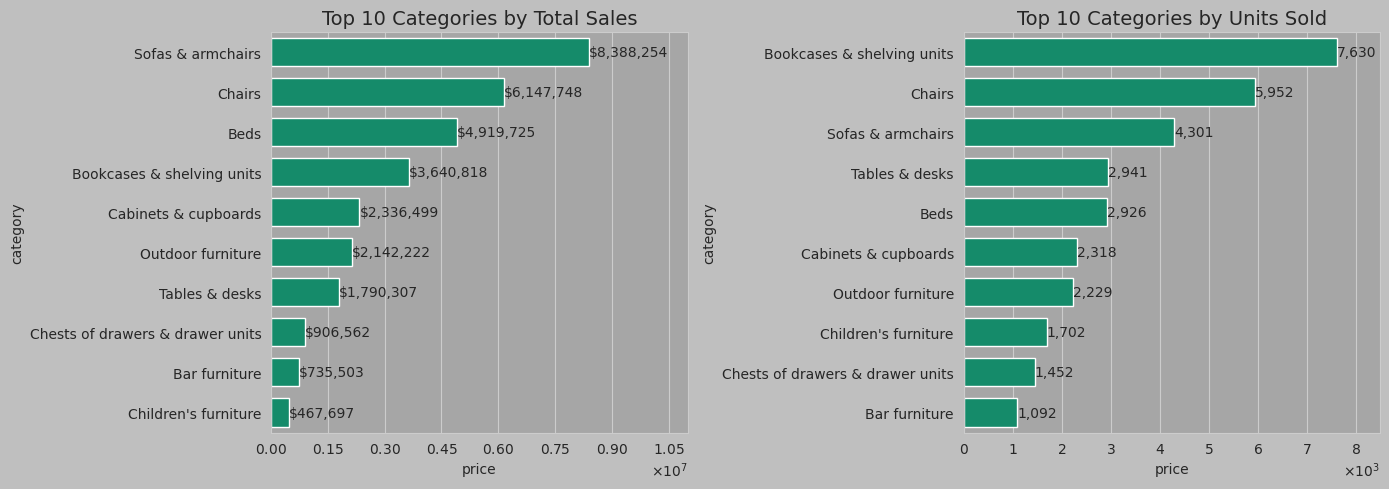

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

plt.gcf().set_facecolor("#bfbfbf")

for axes in ax.flat:
    axes.set_facecolor("#a6a6a6")

sns.set_style("whitegrid")

colors_colorblind = sns.color_palette("colorblind")

# using MaxNLocator to automatically display numbers in scientific notation for all graphs
for axis in ax.flat:
    axis.xaxis.set_major_locator(ticker.MaxNLocator())
    axis.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# [0] Top 10 Categories by Total Sales
category_sales = df.groupby("category")["price"].sum().reset_index().sort_values(by="price", ascending=False).nlargest(10, "price")

sns.barplot(data=category_sales, x="price", y="category", ax=ax[0], color=colors_colorblind[2], errorbar=("ci", False), width=0.7)
ax[0].set_title("Top 10 Categories by Total Sales", fontsize=14, fontweight = "medium")
ax[0].set_xlim(0, 0.11e8)

for bar in ax[0].patches:
    ax[0].text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"${int(bar.get_width()):,}",
        ha="left",
        va="center"
    )

# [1] Top 10 Categories by Units Sold
category_units_sold = df.groupby("category")["price"].count().reset_index().sort_values(by="price", ascending=False).nlargest(10, "price")

sns.barplot(data=category_units_sold, x="price", y="category", ax=ax[1], color=colors_colorblind[2], errorbar=("ci", False), width=0.7)
ax[1].set_title("Top 10 Categories by Units Sold", fontsize=14, fontweight = "medium")
ax[1].set_xlim(0, 8500)

for bar in ax[1].patches:
    ax[1].text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"{int(bar.get_width()):,}",
        ha="left",
        va="center"
    )

plt.tight_layout()
plt.show()

"Sofas & armchairs" drive the highest sales volume. "Bookcases & shelving units" lead in units sold, indicating strong demand. "Chairs" and "Beds" demonstrate consistent high performance across both metrics. The discrepancy between high demand for "Bookcases & shelving units" and their sales volume may suggest potential opportunities to explore monetization strategies, product assortment, or marketing approaches.

**Top Product Categories in the Top-Selling Country**

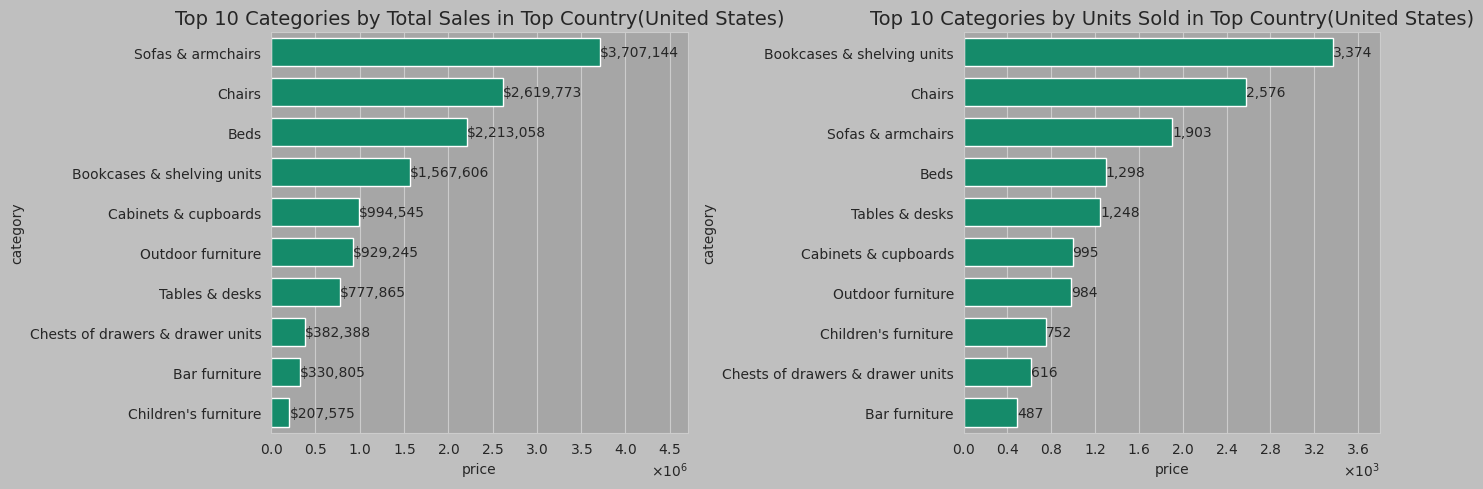

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

plt.gcf().set_facecolor("#bfbfbf")

for axes in ax.flat:
    axes.set_facecolor("#a6a6a6")

sns.set_style("whitegrid")

colors_colorblind = sns.color_palette("colorblind")

# using MaxNLocator to automatically display numbers in scientific notation for all graphs
for axis in ax.flat:
    axis.xaxis.set_major_locator(ticker.MaxNLocator())
    axis.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    axis.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# [0] Top 10 Categories by Total Sales in United States
top_1_country_sales = df.groupby("country")["price"].sum().reset_index().sort_values(by="price", ascending=False).nlargest(1, "price")
category_sales = df[df["country"].isin(top_1_country_sales['country'])].groupby("category")["price"].sum().reset_index().sort_values(by="price", ascending=False).nlargest(10, "price")

sns.barplot(data=category_sales, x="price", y="category", ax=ax[0], color=colors_colorblind[2], errorbar=("ci", False), width=0.7)
ax[0].set_title("Top 10 Categories by Total Sales in Top Country(United States)", fontsize=14, fontweight = "medium")
ax[0].set_xlim(0, 0.47e7)

for bar in ax[0].patches:
    ax[0].text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"${int(bar.get_width()):,}",
        ha="left",
        va="center"
    )

# [1] Top 10 Categories by Units Sold in United States
category_units_sold = df[df["country"].isin(top_1_country_sales['country'])].groupby("category")["price"].count().reset_index().sort_values(by="price", ascending=False).nlargest(10, "price")

sns.barplot(data=category_units_sold, x="price", y="category", ax=ax[1], color=colors_colorblind[2], errorbar=("ci", False), width=0.7)
ax[1].set_title("Top 10 Categories by Units Sold in Top Country(United States)", fontsize=14, fontweight = "medium")
ax[1].set_xlim(0, 3800)

for bar in ax[1].patches:
    ax[1].text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"{int(bar.get_width()):,}",
        ha="left",
        va="center"
    )

plt.tight_layout()
plt.show()


The sales analysis within the United States reveals that "Sofas & armchairs" are a key driver of sales, consistent with the global trend. Simultaneously, the high volume of units sold for "Bookcases & shelving units" indicates significant demand for this product type in the American market. The stable sales and unit volume figures for "Chairs" and "Beds" confirm their importance to the US market.

The discrepancy between "Bookcases & shelving units" leading in unit sales and their ranking in sales volume presents a potential area for exploration.

### In-Depth Sales Analysis

**Sales Distribution by Traffic Channels and Device Types (as % of Total Sales)**

In [ ]:
# Calculate total sales by traffic channel
sales_by_traffic_source = df.groupby("traffic_channel")["price"].sum().reset_index()

# Add percentage share of total sales and sort descending
total_sales = df["price"].sum()
sales_by_traffic_source["percentage"] = round(sales_by_traffic_source["price"] / total_sales * 100, 2)
sales_by_traffic_source = sales_by_traffic_source.sort_values(by="percentage", ascending=False)
sales_by_traffic_source

,traffic_channel,price,percentage
1,Organic Search,11433151.6,35.76
2,Paid Search,8511049.4,26.62
0,Direct,7494923.4,23.44
3,Social Search,2532105.7,7.92
4,Undefined,2000501.0,6.26


In [ ]:
# Calculate total sales by device type
sales_by_device = df.groupby("device")["price"].sum().reset_index()

# Add percentage share of total sales and sort descending
total_sales = df["price"].sum()
sales_by_device["percentage"] = round(sales_by_device["price"] / total_sales * 100, 2)
sales_by_device = sales_by_device.sort_values(by="percentage", ascending=False)
sales_by_device

,device,price,percentage
0,desktop,18864039.0,59.00
1,mobile,12384225.8,38.73
2,tablet,723466.3,2.26


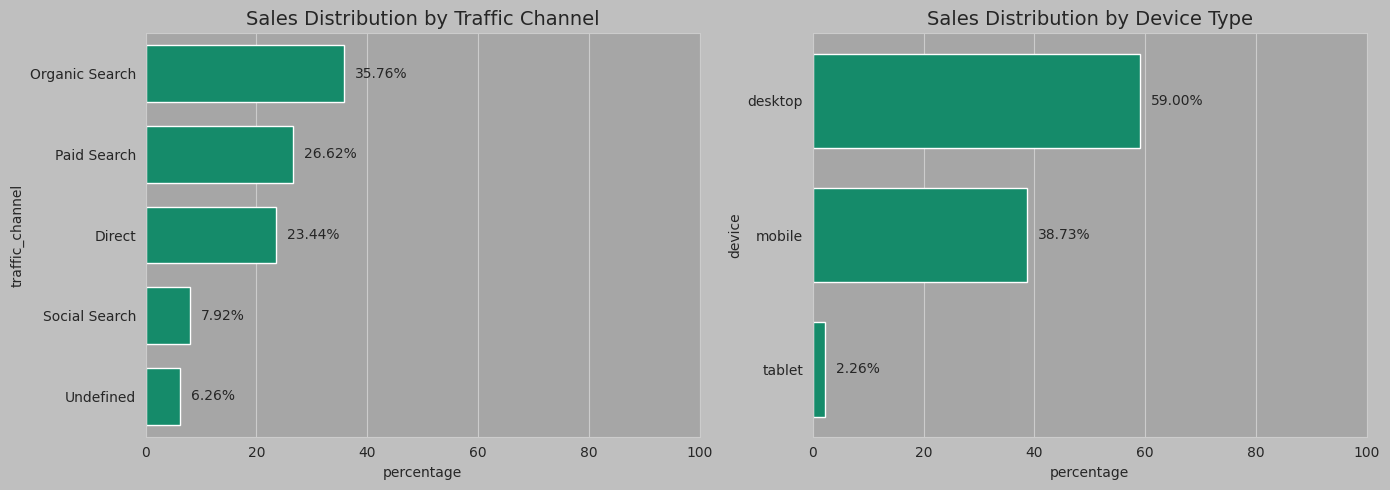

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

plt.gcf().set_facecolor("#bfbfbf")

for axes in ax.flat:
    axes.set_facecolor("#a6a6a6")

sns.set_style("whitegrid")

colors_colorblind = sns.color_palette("colorblind")

# [0] Sales Distribution by Traffic Source
sns.barplot(data=sales_by_traffic_source, x="percentage", y="traffic_channel", ax=ax[0], color=colors_colorblind[2], errorbar=("ci", False), width=0.7)
ax[0].set_title("Sales Distribution by Traffic Channel", fontsize=14, fontweight = "medium")
ax[0].set_xlim(0, 100)

for bar in ax[0].patches:
    ax[0].text(
        bar.get_width() + 2,
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}%",
        ha="left",
        va="center"
    )

# [1] Sales Distribution by Device Type
sns.barplot(data=sales_by_device, x="percentage", y="device", ax=ax[1], color=colors_colorblind[2], errorbar=("ci", False), width=0.7)
ax[1].set_title("Sales Distribution by Device Type", fontsize=14, fontweight = "medium")
ax[1].set_xlim(0, 100)

for bar in ax[1].patches:
    ax[1].text(
        bar.get_width() + 2,
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}%",
        ha="left",
        va="center"
    )

plt.tight_layout()
plt.show()

The main way customers find and buy from us is through search engines, both the free (organic) and paid results, and these channels generate the bulk of our sales. A significant portion of our customers also come directly to our website, indicating a strong level of loyalty. Social media currently plays a smaller role in driving sales. It's noteworthy that most purchases are completed on desktop computers (around 60%), while mobile devices also contribute substantially (around 39%). Tablets are used for making purchases much less often.

Considering this, it's reasonable to infer that users who discover us via search or visit our site directly are more inclined to finalize their purchases on desktops, likely due to a more user-friendly checkout experience. It would be beneficial to analyze the behavior of mobile users, particularly those arriving from search and social media, to identify potential improvements for boosting mobile conversion rates. Furthermore, the "undefined" traffic source warrants investigation to optimize our marketing strategies.

**Visualization and Analysis of Email Verification and Subscription Status**

In [ ]:
is_unsubscribed_counts = df['is_unsubscribed'].value_counts(normalize=True) * 100
is_unsubscribed_counts

,proportion
is_unsubscribed,
True,83.056003
False,16.943997


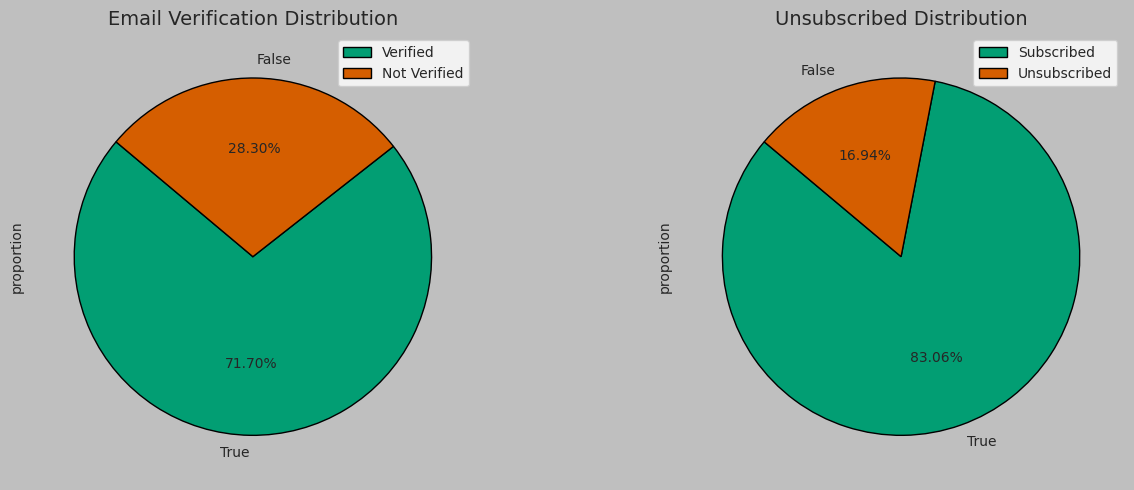

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

plt.gcf().set_facecolor("#bfbfbf")

colors_colorblind = sns.color_palette("colorblind")

# [0] Email Verification Distribution
# Calculate the percentage distribution of email verification status
email_verified_counts = df['is_email_verified'].value_counts(normalize=True) * 100

email_verified_counts.plot.pie(ax=ax[0], autopct='%1.2f%%', startangle=140, colors=colors_colorblind[2:4], wedgeprops={'edgecolor': 'black'})
ax[0].set_title('Email Verification Distribution', fontsize=14, fontweight="medium")
ax[0].legend(labels=['Verified', 'Not Verified'], loc='upper right', fontsize=10)

# [1] Sales Distribution by Device Type
# Calculate the percentage distribution of subscription status (Unsubscribed or Subscribed)
is_unsubscribed_counts = df['is_unsubscribed'].value_counts(normalize=True) * 100

is_unsubscribed_counts.plot.pie(ax=ax[1], autopct='%1.2f%%', startangle=140, colors=colors_colorblind[2:4], wedgeprops={'edgecolor': 'black'})
ax[1].set_title('Unsubscribed Distribution', fontsize=14, fontweight="medium")
ax[1].legend(labels=['Subscribed', 'Unsubscribed'], loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Comparison of subscribers and unsubscribed users based on their purchase behavior.
df_purchase_comparison = df.groupby('is_unsubscribed')['price'].agg(['sum', "mean", 'median', 'count']).reset_index().round(2)

df_purchase_comparison = df_purchase_comparison.rename(columns={
    'sum': 'total_sales',
    'mean': 'average_price',
    'median': 'median_price',
    'count': 'purchase_count'
})

df_purchase_comparison['is_unsubscribed'] = df_purchase_comparison['is_unsubscribed'].map({
    False: "Unsubscribed",
    True: "Subscribed"
})

df_purchase_comparison

,is_unsubscribed,total_sales,average_price,median_price,purchase_count
0,Unsubscribed,431721.6,965.82,450.0,447
1,Subscribed,2150796.9,921.51,395.0,2334


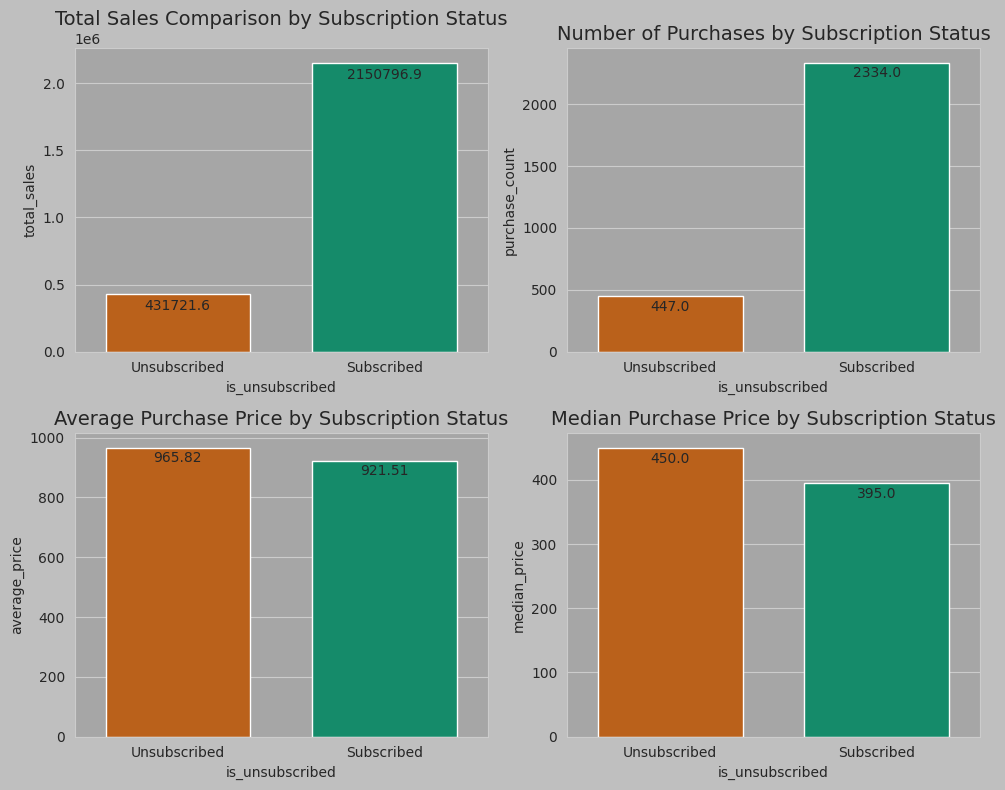

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (10, 8))

plt.gcf().set_facecolor("#bfbfbf")

for axes in ax.flat:
    axes.set_facecolor("#a6a6a6")

sns.set_style("whitegrid")

colors_colorblind = sns.color_palette("colorblind")


# [0, 0] Total Sales Comparison by Subscription Status
sns.barplot(data=df_purchase_comparison, x="is_unsubscribed", y="total_sales", ax=ax[0, 0], hue="is_unsubscribed", palette=colors_colorblind[2:4][::-1], errorbar=("ci", False), width=0.7)
ax[0, 0].set_title("Total Sales Comparison by Subscription Status", fontsize=14, fontweight = "medium")

for bar in ax[0, 0].patches:
  ax[0, 0].text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() - 140000,
      f"{bar.get_height()}",
      ha="center",
      va="bottom",
      fontsize = 10
  )

# [0, 1] Number of Purchases by Subscription Status
sns.barplot(data=df_purchase_comparison, x="is_unsubscribed", y="purchase_count", ax=ax[0, 1], hue="is_unsubscribed", palette=colors_colorblind[2:4][::-1], errorbar=("ci", False), width=0.7)
ax[0, 1].set_title("Number of Purchases by Subscription Status", fontsize=14, fontweight = "medium")

for bar in ax[0, 1].patches:
  ax[0, 1].text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() - 140,
      f"{bar.get_height()}",
      ha="center",
      va="bottom",
      fontsize = 10
  )

# [1, 0] Average Purchase Price by Subscription Status
sns.barplot(data=df_purchase_comparison, x="is_unsubscribed", y="average_price", ax=ax[1, 0], hue="is_unsubscribed", palette=colors_colorblind[2:4][::-1], errorbar=("ci", False), width=0.7)
ax[1, 0].set_title("Average Purchase Price by Subscription Status", fontsize=14, fontweight = "medium")

for bar in ax[1, 0].patches:
  ax[1, 0].text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() - 56,
      f"{bar.get_height()}",
      ha="center",
      va="bottom",
      fontsize = 10
  )

# [1, 1] Median Purchase Price by Subscription Status
sns.barplot(data=df_purchase_comparison, x="is_unsubscribed", y="median_price", ax=ax[1, 1], hue="is_unsubscribed", palette=colors_colorblind[2:4][::-1], errorbar=("ci", False), width=0.7)
ax[1, 1].set_title("Median Purchase Price by Subscription Status", fontsize=14, fontweight = "medium")

for bar in ax[1, 1].patches:
  ax[1, 1].text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() - 28,
      f"{bar.get_height()}",
      ha="center",
      va="bottom",
      fontsize = 10
  )

plt.tight_layout()
plt.show()


1. **Email Verification:**
   - A significant majority of users (≈71.70%) have verified their email addresses, while 28.30% have not. This suggests that most users complete the verification process, which may indicate engagement or trust in the platform.

2. **Subscription Status:**
   - Around 83.06% of users are subscribed, and only 16.94% are unsubscribed. This highlights a strong base of active subscribers.

3. **Sales Comparison – Subscribed vs Unsubscribed:**
   - **Subscribed users** generate a much higher **total sales** amount (≈2,150,796.99) compared to unsubscribed users (≈431,721.60).
   - However, **unsubscribed users** show a slightly higher **average purchase price** (≈965.82 vs ≈921.51) and **median purchase price** (≈450.00 vs ≈395.00).
   - Despite that, the **number of purchases** made by subscribed users (≈2,334) is significantly higher than those made by unsubscribed users (≈447).

 **Conclusion:**
> While unsubscribed users tend to spend more per purchase, subscribed users contribute much more to total revenue due to a significantly higher number of purchases. Therefore, focusing on subscription growth and retention remains key to sustaining and increasing overall sales.

### Sales Dynamics Analysis

**Overall sales dynamics**

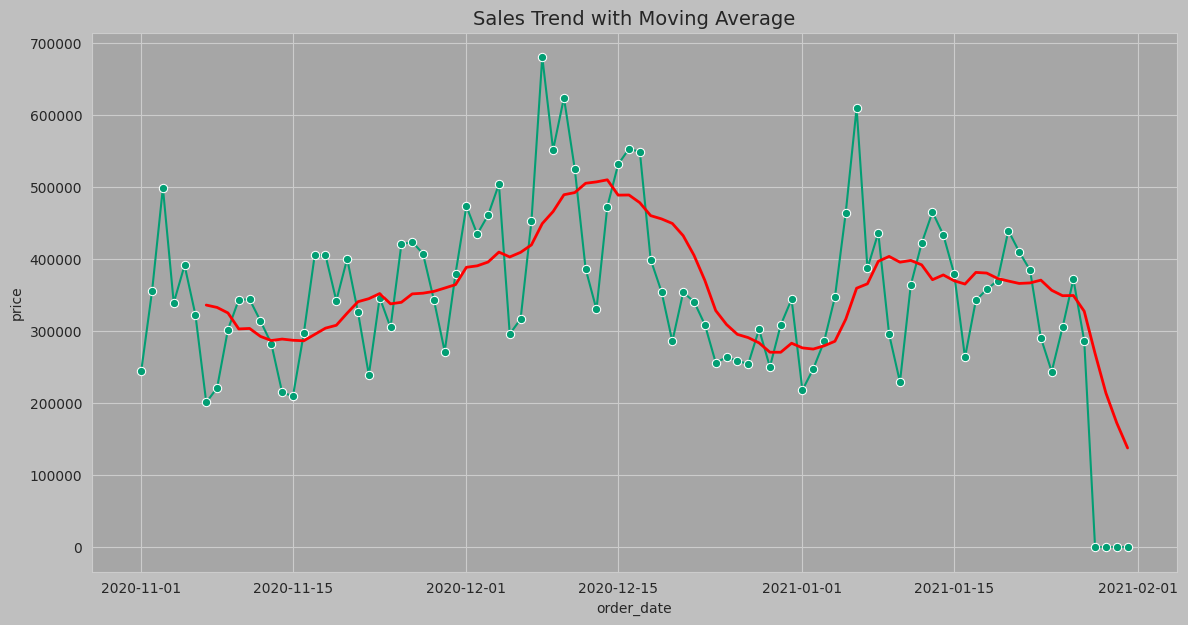

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.set_style("whitegrid")
fig.set_facecolor("#bfbfbf")
ax.set_facecolor("#a6a6a6")

# Group data by 'order_date' and calculate total sales per day
total_sales_by_day = df.groupby('order_date')['price'].sum().reset_index()

sns.lineplot(data=total_sales_by_day, x="order_date", y="price", marker="o", color=colors_colorblind[2])
plt.title('Sales Trend with Moving Average', fontsize=14, fontweight = "medium")

# Calculate 7-day moving average for smoother trend visualization
daily_sales_smoothed = total_sales_by_day['price'].rolling(window=7).mean()
plt.plot(total_sales_by_day['order_date'], daily_sales_smoothed, label='7-Day Moving Average', color='red', linewidth=2)


plt.show()

The sales dynamics during the observed period show significant fluctuations. There's a noticeable increase leading up to mid-December, likely associated with preparations for Christmas and New Year holidays. This is followed by a period of relative stabilization, with new peaks in early January, potentially due to post-holiday sales or other seasonal factors. The 7-day moving average smooths out daily variations, clearly illustrating these key phases.

**Sales Dynamics by Day of the Week**

In [ ]:
# Add a column with the days of the week
df["day_of_the_week"] = df["order_date"].dt.day_name()

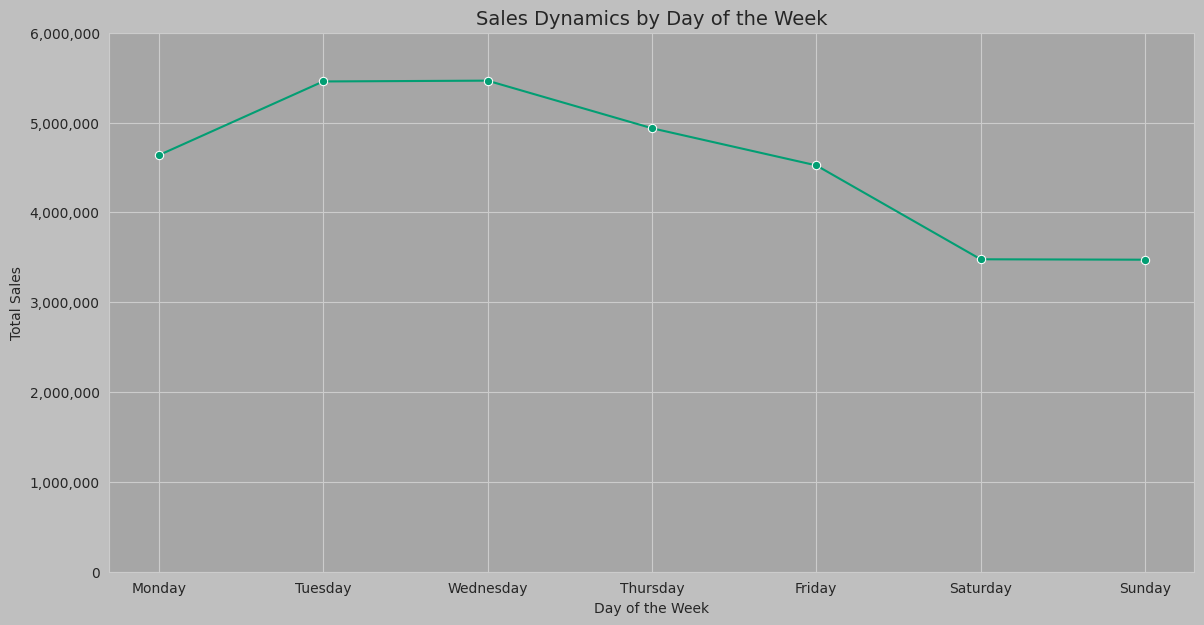

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.set_style("whitegrid")
fig.set_facecolor("#bfbfbf")
ax.set_facecolor("#a6a6a6")

# Convert the "Day of the Week" column to a categorical type with a specified order from Monday to Sunday
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["day_of_the_week"] = pd.Categorical(df["day_of_the_week"], categories=day_order, ordered=True)

# Group data by day of the week and calculate total sales
sales_by_day_of_the_week = df.groupby('day_of_the_week', observed=False)['price'].sum().reset_index()

sns.lineplot(data=sales_by_day_of_the_week, x="day_of_the_week", y="price", marker="o", color=colors_colorblind[2])
plt.title('Sales Dynamics by Day of the Week', fontsize=14, fontweight = "medium")
plt.xlabel("Day of the Week")
plt.ylabel("Total Sales")

# Set Y-axis limits and format numbers with commas for better readability (e.g., 1,000,000 instead of 1e6)
plt.ylim(0, 6000000)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

In [ ]:
sales_by_day_of_the_week

,day_of_the_week,price
0,Monday,4636290.4
1,Tuesday,5457515.9
2,Wednesday,5466542.9
3,Thursday,4936935.6
4,Friday,4523067.2
5,Saturday,3477990.9
6,Sunday,3473388.2



1. **The highest sales** occur on **Wednesday** and **Tuesday**:
   - **Wednesday**: 5,466,542.9
   - **Tuesday**: 5,457,515.9

2. **The lowest sales** occur on **Saturday** and **Sunday**:
   - **Saturday**: 3,477,990.9
   - **Sunday**: 3,473,388.2

3. Overall, **Wednesday** is the most successful day in terms of sales, which might indicate higher demand for products after mid-week when customers are actively planning their purchases.

4. **Saturday** and **Sunday** have the lowest sales, which may reflect decreased customer activity on these days. This could be related to the fact that many purchases typically occur at the beginning of the workweek or just before the weekend.

5. In general, there is a clear cyclical pattern in sales throughout the week, with peaks in the middle of the week and a decline in activity on the weekends.

These insights can be useful for adjusting marketing strategies, planning promotions, and discounts based on the day of the week. For instance, you could focus on boosting promotions on Monday and Wednesday, when sales are highest, or reassess strategies for Saturday and Sunday to improve performance on these days.

**Sales Dynamics by Continents**

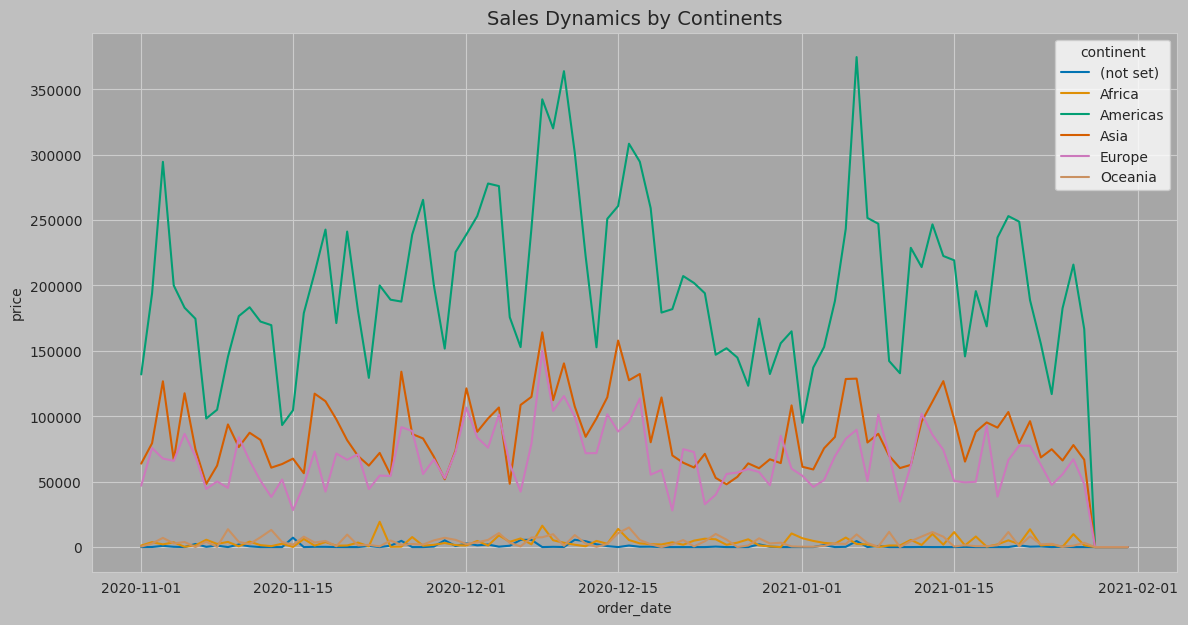

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.set_style("whitegrid")
fig.set_facecolor("#bfbfbf")
ax.set_facecolor("#a6a6a6")

# Group the data by order_date and continent, then calculate the total sales for each group
sales_by_continent = df.groupby(["order_date", "continent"], observed=False)["price"].sum().reset_index()

sns.lineplot(data=sales_by_continent, x="order_date", y="price", hue="continent", palette="colorblind")
plt.title('Sales Dynamics by Continents', fontsize=14, fontweight = "medium")

plt.show()

The analysis of sales dynamics by continent reveals a clear hierarchy of markets, with the Americas being the undisputed leader, exhibiting a significant lead and the most pronounced fluctuations in sales volumes throughout the observed period. These fluctuations may be attributed to both internal factors within the American market and global events.

Asia stands as the second-largest market, demonstrating noticeable variations, although with a smaller amplitude compared to the Americas. Europe is characterized by a more stable sales dynamic, lacking sharp increases or decreases, which may indicate more established consumer habits or lower sensitivity to external influences.

Africa and Oceania remain markets with minimal sales volumes, potentially suggesting a smaller presence of our products or other market-specific characteristics in these regions.

The synchronized peaks and troughs, particularly evident in the sales dynamics of the Americas and Asia, warrant further attention. This may indicate the presence of shared external factors, such as seasonality, macroeconomic trends, or global marketing campaigns, that simultaneously influence consumer behavior in these regions. Further analysis could focus on identifying these common factors and their impact on each market.

**Sales Dynamics by Device Type**

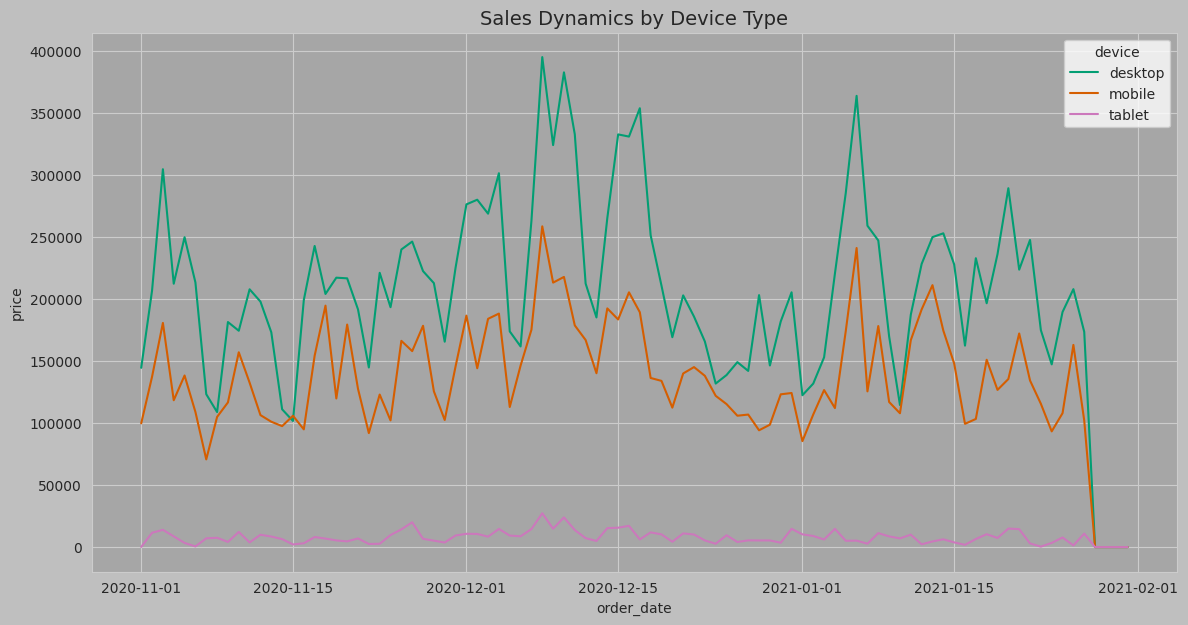

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.set_style("whitegrid")
fig.set_facecolor("#bfbfbf")
ax.set_facecolor("#a6a6a6")

# Group the data by order_date and device, then calculate the total sales for each group
sales_by_continent = df.groupby(["order_date", "device"], observed=False)["price"].sum().reset_index()

sns.lineplot(data=sales_by_continent, x="order_date", y="price", hue="device", palette=colors_colorblind[2:5])
plt.title('Sales Dynamics by Device Type', fontsize=14, fontweight = "medium")

plt.show()

Analyzing sales dynamics by device type reveals that desktop remains the primary channel, generating the largest sales volume but exhibiting significant volatility. Mobile devices consistently hold the second position, demonstrating fluctuations throughout the period but generally maintaining a level higher than tablet sales. Tablet sales remain low. Interestingly, sales peaks on desktops often correlate with increased sales on mobile devices, suggesting shared periods of heightened consumer activity.

Given the increasing role of mobile devices, optimizing the mobile user experience is a key priority for further increasing sales. Aligning marketing strategies across desktop and mobile platforms during peak activity periods can maximize their effectiveness. In-depth analysis of user behavior on each device type will help identify additional opportunities for personalization of offers and conversion improvement.

**Sales Dynamics by Traffic Channel**

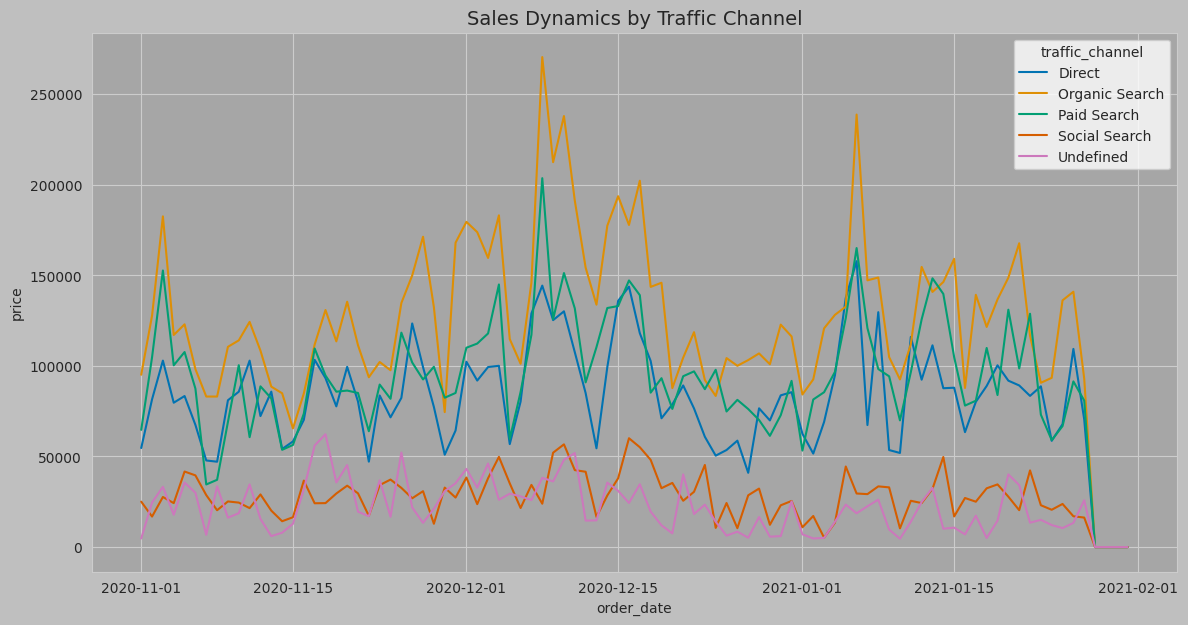

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.set_style("whitegrid")
fig.set_facecolor("#bfbfbf")
ax.set_facecolor("#a6a6a6")

# Group the data by order_date and traffic_channel, then calculate the total sales for each group
sales_by_continent = df.groupby(["order_date", "traffic_channel"], observed=False)["price"].sum().reset_index()

sns.lineplot(data=sales_by_continent, x="order_date", y="price", hue="traffic_channel", palette="colorblind")
plt.title('Sales Dynamics by Traffic Channel', fontsize=14, fontweight = "medium")

plt.show()

Analyzing sales dynamics by traffic channel, we observe that Organic Search is the consistent leader during the period, providing the largest sales volume. Paid Search holds the second position, demonstrating noticeable fluctuations but generally remaining an important revenue source. Direct traffic is also a significant channel with relatively stable dynamics, indicating a loyal audience. Social Search and Undefined traffic sources have considerably lower sales volumes.

Given the dominance of Organic and Paid Search, maintaining and optimizing SEO and SEM strategies are key. The growth of Direct traffic should be encouraged by increasing brand awareness and customer loyalty. The low effectiveness of Social Search and Undefined sources requires further investigation to identify optimization opportunities or reallocation of marketing efforts.

## Pivot Tables

**Session Count by Traffic Channels and Device Types**

In [ ]:
# Create a pivot table to count the number of sessions by traffic channel and device type
sessions_by_channel_and_device = pd.pivot_table(df, values="ga_session_id", index="traffic_channel", columns="device", aggfunc="count")
sessions_by_channel_and_device

device,desktop,mobile,tablet
traffic_channel,,,
Direct,47825,31745,1812
Organic Search,72622,49014,2789
Paid Search,55167,37034,2140
Social Search,16288,10988,638
Undefined,12527,8486,470


The desktop remains the dominant device type across all traffic channels, especially in Organic Search and Paid Search. However, mobile usage is also significant, particularly for Organic Search and Paid Search traffic. Tablet usage is consistently low across all channels.

**Total Sales by Product Categories (Top 10) in Top 5 Countries**

In [ ]:
top_5_countries = df.groupby("country")["price"].sum().nlargest(5).index
top_10_categories = df.groupby("category")["price"].sum().nlargest(10).index

# Filter the original DataFrame to include only top 5 countries and top 10 categories
filtered_df = df[df["country"].isin(top_5_countries) & df["category"].isin(top_10_categories)]

# Create a pivot table showing total sales by category (rows) and country (columns)
top10_category_sales_in_top5_countries = pd.pivot_table(filtered_df, values="price", index="category", columns="country", aggfunc="sum")
top10_category_sales_in_top5_countries

country,Canada,France,India,United Kingdom,United States
category,,,,,
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
Children's furniture,30264.0,14258.0,39177.0,13348.0,207575.0
Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5


The pivot table shows that "Sofas & armchairs" and "Chairs" are the top-selling categories across all top 5 countries, especially in the United States, which consistently leads in total sales across all categories. This suggests strong customer interest in seating furniture. Other high-performing categories include "Beds" and "Bookcases & shelving units".

**Average Sales by Product Categories and Device Types**

In [ ]:
# Create a pivot table to calculate the average sales (price) by product category and device type
avg_sales_by_category_and_device = pd.pivot_table(df, index="category", values="price", columns="device", aggfunc="mean")
avg_sales_by_category_and_device

device,desktop,mobile,tablet
category,,,
Bar furniture,668.829721,686.378571,583.076923
Beds,1708.848241,1646.089076,1612.550847
Bookcases & shelving units,479.979130,473.538089,468.117722
Cabinets & cupboards,1001.666788,1006.662162,1201.666667
Café furniture,386.244131,373.225352,725.000000
Chairs,1058.552438,984.076257,1186.813139
Chests of drawers & drawer units,627.390898,617.685739,668.259259
Children's furniture,276.459064,269.895963,319.906250
Nursery furniture,382.088106,326.308176,373.750000


The average sales vary across product categories and device types. Generally, high-ticket items like Sofas & armchairs and Beds have the highest average prices across all devices. Interestingly, some categories such as Chairs and Cabinets & cupboards show higher average prices on tablet devices, which may suggest a tendency for higher-value purchases from those devices. Lower average prices are seen in categories like Children's furniture and Nursery furniture, regardless of the device.

**Session Count by Top 10 Countries and Operating System Types**

In [ ]:
# Filter the data to include only the top 10 countries by total revenue
top_10_country = df.groupby("country")["price"].sum().nlargest(10).index
df_top_10_country = df[df["country"].isin(top_10_country)]

# Create a pivot table showing the number of sessions by country and operating system
sessions_and_revenue_by_country_and_os = pd.pivot_table(df_top_10_country, index="country", values="ga_session_id", columns="operating_system", aggfunc="count")
sessions_and_revenue_by_country_and_os

operating_system,<Other>,Android,Macintosh,Web,Windows,iOS
country,,,,,,
Canada,670,2222,1966,15098,2978,3060
China,143,528,430,3444,747,774
France,156,548,549,4069,890,746
Germany,148,527,463,3625,760,673
India,780,2708,2429,19272,3782,3792
Singapore,90,392,343,2718,501,550
Spain,188,555,461,3753,792,756
Taiwan,154,451,409,3552,630,683
United Kingdom,288,931,813,6431,1311,1229


Main operating systems: The web version (Web) has the highest number of sessions in most countries, indicating a high demand for access through browsers. For example, in the US and India, the number of web sessions significantly exceeds those from other operating systems.

Mobile platforms usage: Android and iOS show substantial activity, especially in countries like India, the US, and Canada, where mobile platforms have a significant user share.

Windows usage: The number of sessions on the Windows platform is also quite high, particularly in the US and India.

## Statistical Analysis

**Daily Relationship Between Sessions and Sales**

In [ ]:
# Calculate total daily sales and number of unique sessions
session_and_sales_by_date = df.groupby("order_date").agg(session=("ga_session_id", 'nunique'), total_sales=("price", "sum")).reset_index()
session_and_sales_by_date.head()

,order_date,session,total_sales
0,2020-11-01,2576,244292.5
1,2020-11-02,3599,355506.8
2,2020-11-03,5173,498979.6
3,2020-11-04,4184,339187.1
4,2020-11-05,3743,391276.6


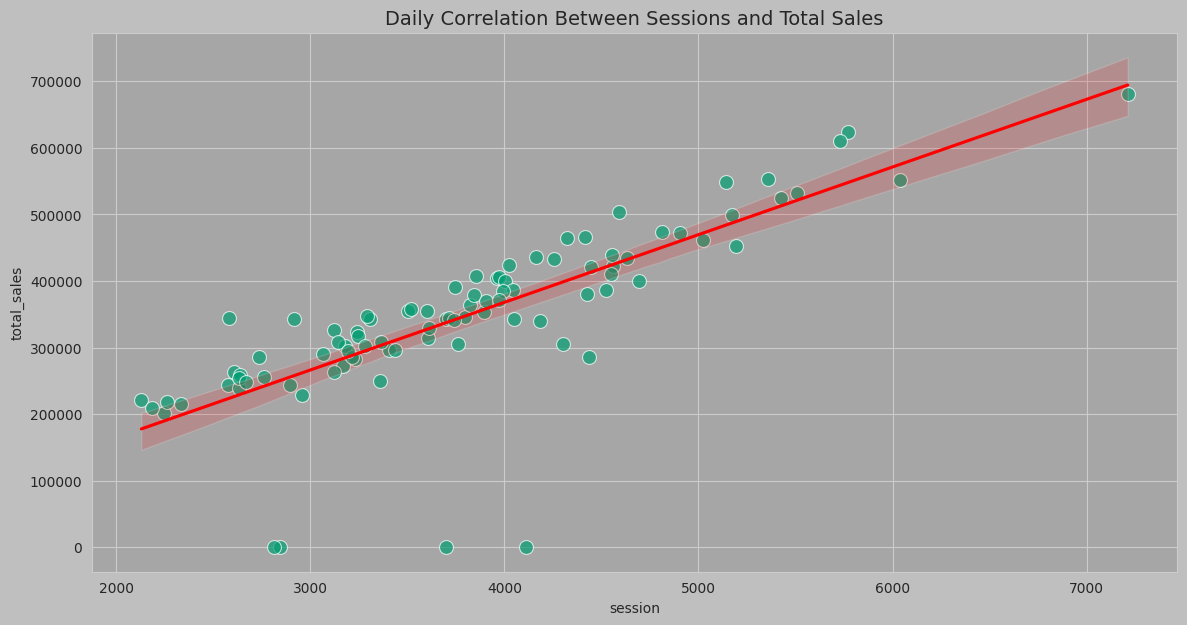

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.set_style("whitegrid")
fig.set_facecolor("#bfbfbf")
ax.set_facecolor("#a6a6a6")

sns.scatterplot(data=session_and_sales_by_date, x='session', y='total_sales', color=colors_colorblind[2], s=100, alpha=0.7)

# adding a trend line for trend analysis
sns.regplot(data=session_and_sales_by_date, x='session', y='total_sales', scatter=False, color='red')

plt.title('Daily Correlation Between Sessions and Total Sales', fontsize=14, fontweight = "medium")

plt.show()

In [ ]:
# calculating the correlation between Sessions and Sales
correlation = session_and_sales_by_date['session'].corr(session_and_sales_by_date['total_sales'])
print(f"Correlation between Sessions and Sales: {correlation:.2f}")

Correlation between Sessions and Sales: 0.79


In [ ]:
# Calculating the Pearson correlation coefficient and p-value
corr_coefficient, p_value = pearsonr(session_and_sales_by_date['session'], session_and_sales_by_date['total_sales'])

print(f"Pearson Correlation Coefficient: {corr_coefficient:.2f}")
print(f"P-value: {p_value:.3f}")

Pearson Correlation Coefficient: 0.79
P-value: 0.000



Pearson Correlation Coefficient: 0.79  
  This indicates a **strong positive relationship** between the number of unique sessions and total sales. An increase in the number of sessions on the website is likely to result in higher sales volumes.

 The p-value is **0.000**, which is lower than the standard significance level of 0.05. This suggests that the correlation between sessions and sales is **statistically significant**.

There is a strong and statistically significant positive correlation between sessions and sales. This suggests that increasing the number of unique sessions on the website may potentially lead to an increase in total sales. This insight can be valuable for future marketing strategies and website optimization.


**Sales Correlation Between the Top 3 Continents**

In [ ]:
# Get the top 3 continents by total sales
top_3_continents_by_sales = df.groupby("continent")["price"].sum().nlargest(3).index

# Filter the dataset to include only rows from the top 3 continents
df_top_3_continents = df[df["continent"].isin(top_3_continents_by_sales)]

# Calculate total sales per day for each of the top 3 continents
sales_top_continents_by_day = df_top_3_continents.groupby(["order_date", "continent"])["price"].sum().reset_index()

# Pivot the data so that each continent becomes a column, and rows represent daily sales
sales_pivot = pd.pivot_table(data=sales_top_continents_by_day, index="order_date", columns="continent", values="price")

# Calculate the correlation matrix between the daily sales of the top 3 continents
correlation_matrix = sales_pivot.corr()

correlation_matrix

continent,Americas,Asia,Europe
continent,,,
Americas,1.000000,0.792025,0.770586
Asia,0.792025,1.000000,0.768427
Europe,0.770586,0.768427,1.000000


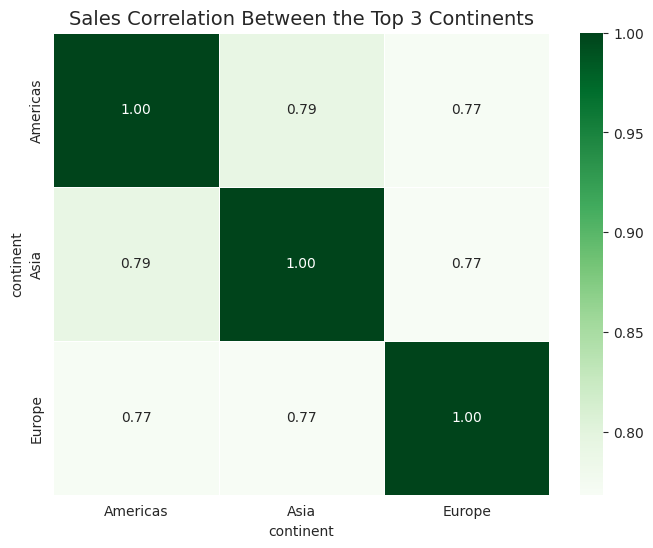

In [ ]:
# Heatmap for correlation between top 3 continents
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

sns.heatmap(correlation_matrix, cmap="Greens", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Sales Correlation Between the Top 3 Continents", fontsize=14, fontweight="medium")

plt.show()

In [ ]:
# Create a DataFrame to store p-values for correlation between different traffic channels
p_value_matrix = pd.DataFrame(index=sales_pivot.columns, columns=sales_pivot.columns)

# Calculate the p-value for each pair of traffic channels
for col1 in sales_pivot.columns:
    for col2 in sales_pivot.columns:
        _, p_value = pearsonr(sales_pivot[col1].dropna(), sales_pivot[col2].dropna())
        p_value_matrix.loc[col1, col2] = f"{p_value:.4f}"

p_value_matrix


continent,Americas,Asia,Europe
continent,,,
Americas,0.0000,0.0000,0.0000
Asia,0.0000,0.0000,0.0000
Europe,0.0000,0.0000,0.0000


The correlation analysis of daily sales volumes among the top three continents by sales volume – Americas, Asia, and Europe – reveals a strong positive correlation between all pairs. The Pearson correlation coefficient between Americas and Asia is 0.79, between Americas and Europe is 0.77, and between Asia and Europe is 0.77. These high values indicate a significant tendency for sales volumes in these continents to increase or decrease simultaneously.

The p-value for all correlation pairs is low (0.0000), indicating a high level of statistical significance for these correlations. This means that the observed relationships between daily sales in these three continents are not random and are likely driven by common factors such as global economic trends, seasonality, marketing campaigns, or other external influences that simultaneously affect these key markets.

**Correlation Between Sales from Different Traffic Channels**

In [ ]:
# Group the data by order date and traffic channel, summing the price for each group
sales_by_channel_and_date = df.groupby(["order_date", "traffic_channel"])["price"].sum().reset_index()

# Pivot the data so that each traffic channel becomes a column, and rows represent daily sales
sales_pivot_2 = pd.pivot_table(data=sales_by_channel_and_date, index="order_date", columns="traffic_channel", values="price")

# Calculate the correlation matrix between daily sales of different traffic channels
correlation_matrix_2 = sales_pivot_2.corr()

correlation_matrix_2


traffic_channel,Direct,Organic Search,Paid Search,Social Search,Undefined
traffic_channel,,,,,
Direct,1.000000,0.837833,0.814072,0.604060,0.517505
Organic Search,0.837833,1.000000,0.870086,0.583117,0.526068
Paid Search,0.814072,0.870086,1.000000,0.596428,0.521961
Social Search,0.604060,0.583117,0.596428,1.000000,0.455126
Undefined,0.517505,0.526068,0.521961,0.455126,1.000000


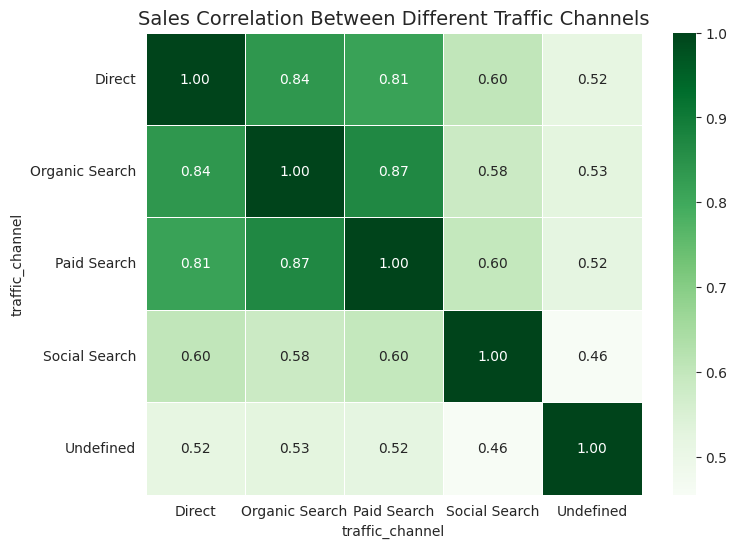

In [ ]:
# Heatmap for correlation between different traffic channels
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

sns.heatmap(correlation_matrix_2, cmap="Greens", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Sales Correlation Between Different Traffic Channels", fontsize=14, fontweight="medium")

plt.show()

In [ ]:
# Create a DataFrame to store p-values for correlation between different traffic channels
p_value_matrix_2 = pd.DataFrame(index=sales_pivot_2.columns, columns=sales_pivot_2.columns)

# Calculate the p-value for each pair of traffic channels
for col1 in sales_pivot_2.columns:
    for col2 in sales_pivot_2.columns:
        _, p_value = pearsonr(sales_pivot_2[col1].dropna(), sales_pivot_2[col2].dropna())
        p_value_matrix_2.loc[col1, col2] = f"{p_value:.8f}"

p_value_matrix_2


traffic_channel,Direct,Organic Search,Paid Search,Social Search,Undefined
traffic_channel,,,,,
Direct,0.00000000,0.00000000,0.00000000,0.00000000,0.00000013
Organic Search,0.00000000,0.00000000,0.00000000,0.00000000,0.00000007
Paid Search,0.00000000,0.00000000,0.00000000,0.00000000,0.00000010
Social Search,0.00000000,0.00000000,0.00000000,0.00000000,0.00000516
Undefined,0.00000013,0.00000007,0.00000010,0.00000516,0.00000000


The correlation analysis of daily sales volumes between different traffic channels reveals a strong positive correlation among the main channels: Direct, Organic Search, and Paid Search. The correlation coefficients between these three channels range from 0.81 to 0.87, indicating that sales volumes from these sources tend to move in the same direction. This may suggest common factors influencing overall purchasing activity or the effectiveness of marketing efforts that could have a synergistic effect.

The correlation between Social Search and the main channels (Direct, Organic Search, Paid Search) is noticeably weaker, although still positive (ranging from 0.58 to 0.60). This could indicate that sales from social media have somewhat different dynamics or are less dependent on the same factors influencing search channels and direct visits. The Undefined channel shows the weakest correlation with all other channels (ranging from 0.45 to 0.53), which may be due to its unclear nature and potentially diverse traffic sources falling into this category.

The p-values for all channel pairs are extremely low (around 0.0000), confirming the high statistical significance of the identified correlations. This means that the observed relationships between daily sales for these channels are not random.

**Correlation Between Sales of the Top 5 Product Categories**

In [ ]:
top_5_categories = df.groupby("category")["price"].sum().nlargest(5).index
filtered_df_top_5_categories = df[df["category"].isin(top_5_categories)]

# Group the filtered data by order date and category, then sum the prices (sales)
sales_by_categories_and_date = filtered_df_top_5_categories.groupby(["order_date", "category"])["price"].sum().reset_index()

# Create a pivot table
sales_pivot_3 = pd.pivot_table(data=sales_by_categories_and_date, index="order_date", columns="category", values="price")

# Calculate the correlation matrix between the sales of the top 5 categories
correlation_matrix_3 = sales_pivot_3.corr()

correlation_matrix_3

category,Beds,Bookcases & shelving units,Cabinets & cupboards,Chairs,Sofas & armchairs
category,,,,,
Beds,1.000000,0.592913,0.514609,0.554500,0.535378
Bookcases & shelving units,0.592913,1.000000,0.539428,0.637090,0.666194
Cabinets & cupboards,0.514609,0.539428,1.000000,0.572870,0.657563
Chairs,0.554500,0.637090,0.572870,1.000000,0.578248
Sofas & armchairs,0.535378,0.666194,0.657563,0.578248,1.000000


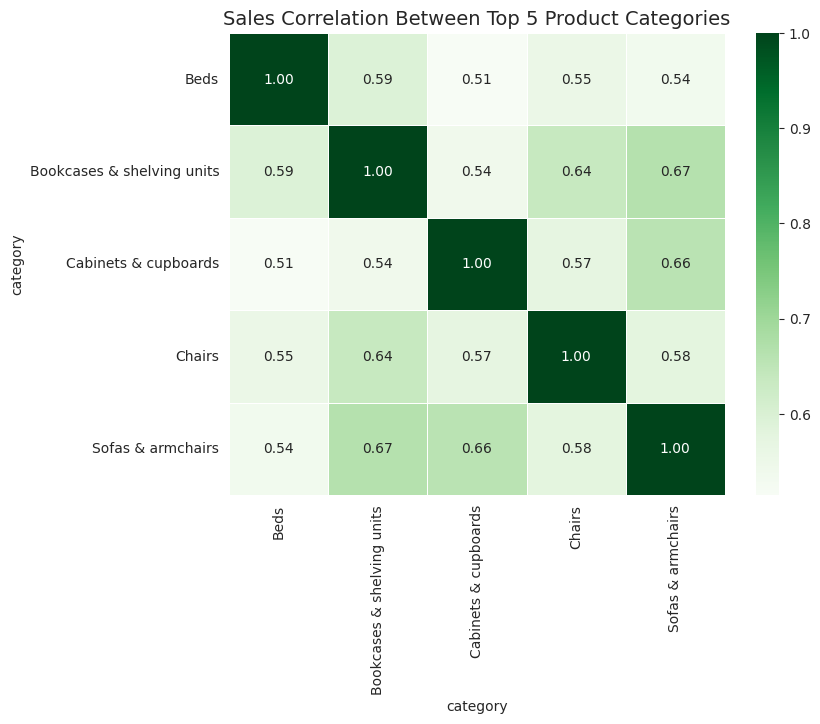

In [ ]:
# Heatmap for correlation between top 5 product categories
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

sns.heatmap(correlation_matrix_3, cmap="Greens", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Sales Correlation Between Top 5 Product Categories", fontsize=14, fontweight="medium")

plt.show()

In [ ]:
# Create a DataFrame to store p-values for correlation between top 5 product categories
p_value_matrix_3 = pd.DataFrame(index=sales_pivot_3.columns, columns=sales_pivot_3.columns)

# Calculate the p-value for each pair of top 5 product categories
for col1 in sales_pivot_3.columns:
  for col2 in sales_pivot_3.columns:
    _, p_value = pearsonr(sales_pivot_3[col1].dropna(), sales_pivot_3[col2].dropna())
    p_value_matrix_3.loc[col1, col2] = f"{p_value:.8f}"

p_value_matrix_3

category,Beds,Bookcases & shelving units,Cabinets & cupboards,Chairs,Sofas & armchairs
category,,,,,
Beds,0.00000000,0.00000000,0.00000029,0.00000002,0.00000008
Bookcases & shelving units,0.00000000,0.00000000,0.00000006,0.00000000,0.00000000
Cabinets & cupboards,0.00000029,0.00000006,0.00000000,0.00000001,0.00000000
Chairs,0.00000002,0.00000000,0.00000001,0.00000000,0.00000000
Sofas & armchairs,0.00000008,0.00000000,0.00000000,0.00000000,0.00000000


The correlation analysis of daily sales among the top 5 product categories reveals moderate positive relationships between most pairs. The strongest correlations are observed between "Bookcases & shelving units" and "Sofas & armchairs," as well as between "Sofas & armchairs" and "Cabinets & cupboards," potentially indicating shared purchasing patterns when furnishing spaces. Correlations involving the "Beds" category are somewhat weaker.

These identified relationships can be leveraged to optimize product recommendations and cross-selling strategies. For example, suggesting items from strongly correlated categories together could increase the average order value. Weaker correlations for certain categories might signal the need for different promotional approaches.

## Statistical Tests

**Testing for a statistically significant difference in sales between registered and unregistered users.**

In [ ]:
# Filter rows with registered users, then group by order_date and sum the sales
registered_daily_sales = df[df["user_id"].notna()].groupby("order_date")["price"].sum().reset_index()

# Filter rows with unregistered users, then group by order_date and sum the sales
unregistered_daily_sales = df[df["user_id"].isna()].groupby("order_date")["price"].sum().reset_index()

print(f"Registered daily sales shape (rows, columns): {registered_daily_sales.shape}")
print(f"Unregistered daily sales shape (rows, columns): {unregistered_daily_sales.shape}")


Registered daily sales shape (rows, columns): (88, 2)
Unregistered daily sales shape (rows, columns): (92, 2)


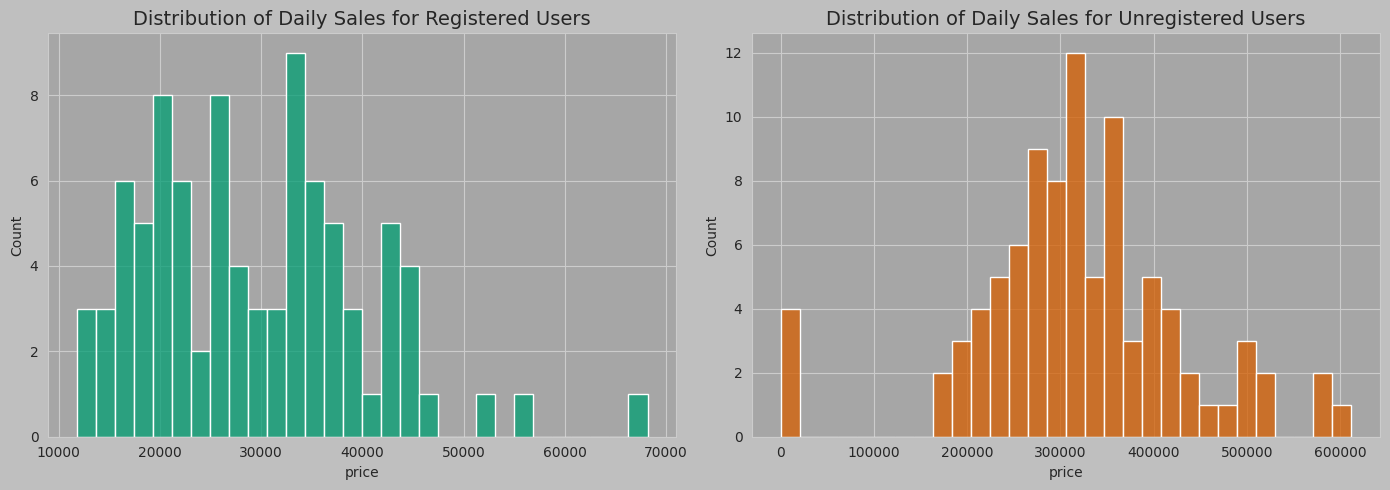

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.set_style("whitegrid")
fig.set_facecolor("#bfbfbf")
for axes in ax.flat:
    axes.set_facecolor("#a6a6a6")

# [0] Plot the histogram of daily sales for registered users
sns.histplot(registered_daily_sales["price"], bins=30, ax=ax[0], color=colors_colorblind[2])
ax[0].set_title("Distribution of Daily Sales for Registered Users", fontsize=14, fontweight = "medium")

# [1] Plot the histogram of daily sales for unregistered users
sns.histplot(unregistered_daily_sales["price"], bins=30, ax=ax[1], color=colors_colorblind[3])
ax[1].set_title("Distribution of Daily Sales for Unregistered Users", fontsize=14, fontweight = "medium")

plt.tight_layout()
plt.show()

In [ ]:
# Normality test for the sales distribution of registered and unregistered users(Shapiro-Wilk test)

stat_reg, p_value_reg = shapiro(registered_daily_sales["price"])
stat_unreg, p_value_unreg = shapiro(unregistered_daily_sales["price"])

if p_value_reg < 0.05:
    print(f"Registered users: p-value = {p_value_reg:.4f} → Distribution is not normal")
else:
    print(f"Registered users: p-value = {p_value_reg:.4f} → Distribution is normal")

if p_value_unreg < 0.05:
    print(f"Unregistered users: p-value = {p_value_unreg:.4f} → Distribution is not normal")
else:
    print(f"Unregistered users: p-value = {p_value_unreg:.4f} → Distribution is normal")


Registered users: p-value = 0.0073 → Distribution is not normal
Unregistered users: p-value = 0.0012 → Distribution is not normal


In [ ]:
# Perform the Mann-Whitney U test to check for a statistically significant difference between the two groups

u_stat, p_value = mannwhitneyu(registered_daily_sales["price"], unregistered_daily_sales["price"])

if p_value < 0.05:
    print(f"Mann-Whitney U test: p-value = {p_value:.4f} → There is a statistically significant difference between the two groups")
else:
    print(f"Mann-Whitney U test: p-value = {p_value:.4f} → There is no statistically significant difference between the two groups")

Mann-Whitney U test: p-value = 0.0000 → There is a statistically significant difference between the two groups


Hypotheses Formulation:

- Null Hypothesis (H0):
There is no statistically significant difference in the daily sales volumes between registered and unregistered users.

- Alternative Hypothesis (H1):
There is a statistically significant difference in the daily sales volumes between registered and unregistered users.

The analysis of the daily sales distribution using the Shapiro-Wilk test revealed a deviation from the normal distribution for both registered (p = 0.0073) and unregistered (p = 0.0012) users. Therefore, the non-parametric Mann-Whitney U test was used to compare the average sales values between these groups.

The results of the Mann-Whitney U test showed a statistically significant difference in the daily sales volumes between registered and unregistered users (p < 0.0001). This provides evidence to suggest that there is a significant difference in the sales levels between these two customer groups.

**Testing for differences in the number of sessions across traffic channels.**

In [ ]:
# Checking unique traffic channels
df["traffic_channel"].unique()

array(['Paid Search', 'Organic Search', 'Direct', 'Undefined',
       'Social Search'], dtype=object)

In [ ]:
# Grouping data: counting daily unique sessions by traffic channel
daily_sessions_by_channel = df.groupby(['order_date', 'traffic_channel'])['ga_session_id'].nunique().reset_index()

# Pivot table: traffic channels as columns, dates as rows
pivot_sessions = daily_sessions_by_channel.pivot_table(index='order_date', columns='traffic_channel', values='ga_session_id')

# Filling missing values with 0
pivot_sessions = pivot_sessions.fillna(0)

In [ ]:
# Counting number of unique days per channel
sample_sizes = daily_sessions_by_channel.groupby('traffic_channel')['order_date'].nunique()

sample_sizes

,order_date
traffic_channel,
Direct,92
Organic Search,92
Paid Search,92
Social Search,92
Undefined,92


In [ ]:
# Shapiro-Wilk test for normality
for column in pivot_sessions.columns:
    stat, p = shapiro(pivot_sessions[column])
    print(f"{column}: p-value = {p:.4f} → {'Not normal' if p < 0.05 else 'Normal'}")

Direct: p-value = 0.0343 → Not normal
Organic Search: p-value = 0.0123 → Not normal
Paid Search: p-value = 0.0108 → Not normal
Social Search: p-value = 0.1413 → Normal
Undefined: p-value = 0.0546 → Normal


In [ ]:
# Preparing data as separate lists per channel for Kruskal-Wallis test
group_values = [pivot_sessions[col] for col in pivot_sessions.columns]

# Kruskal-Wallis H-test for independent samples (non-parametric alternative to ANOVA)
stat, p_value = kruskal(*group_values)

if p_value < 0.05:
    print(f"Kruskal-Wallis test: p-value = {p_value:.4f} → Statistically significant differences between groups")
else:
    print(f"Kruskal-Wallis test: p-value = {p_value:.4f} → No statistically significant differences between groups")

Kruskal-Wallis test: p-value = 0.0000 → Statistically significant differences between groups


In [ ]:
# Resetting index to allow melting from wide to long format
pivot_sessions = pivot_sessions.reset_index()

In [ ]:
# Melting data into long format for posthoc testing
sessions_long = pivot_sessions.melt(id_vars='order_date', var_name='traffic_channel', value_name='ga_session_id')

# Post hoc Dunn's test with Bonferroni correction
posthoc = sp.posthoc_dunn( sessions_long, val_col='ga_session_id', group_col='traffic_channel', p_adjust='bonferroni')

print(posthoc.to_string())

                      Direct  Organic Search   Paid Search  Social Search     Undefined
Direct          1.000000e+00    6.323122e-08  4.326742e-01   4.304460e-15  4.847586e-23
Organic Search  6.323122e-08    1.000000e+00  1.525628e-03   3.740352e-43  4.546360e-56
Paid Search     4.326742e-01    1.525628e-03  1.000000e+00   3.286805e-23  6.982112e-33
Social Search   4.304460e-15    3.740352e-43  3.286805e-23   1.000000e+00  4.735275e-01
Undefined       4.847586e-23    4.546360e-56  6.982112e-33   4.735275e-01  1.000000e+00


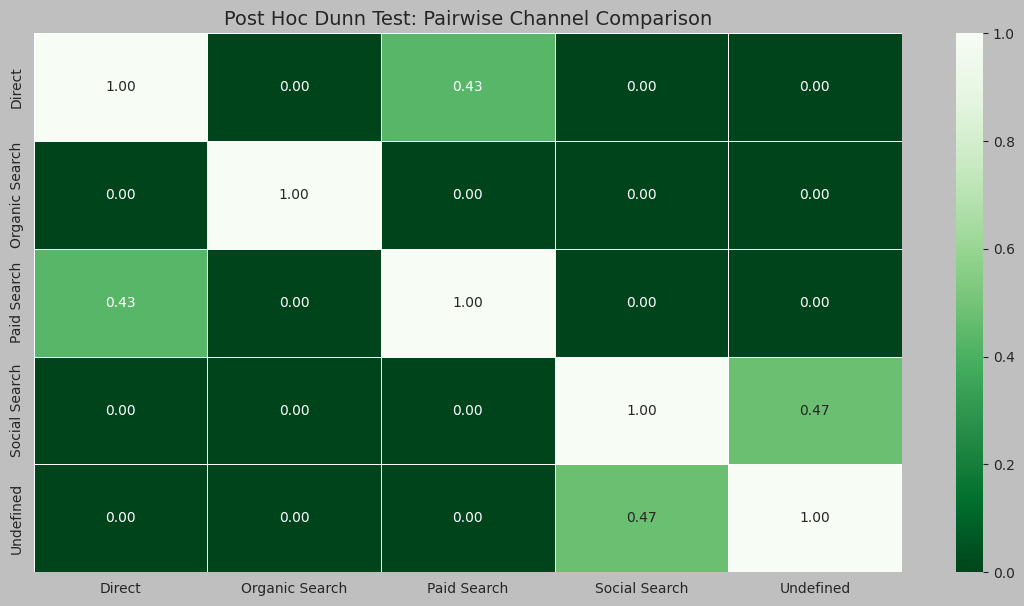

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.set_style("whitegrid")
fig.set_facecolor("#bfbfbf")

# Heatmap of p-values from Dunn's test
sns.heatmap(data=posthoc, cmap="Greens_r", annot=True, fmt=".2f", linewidths=0.5)

plt.title("Post Hoc Dunn Test: Pairwise Channel Comparison", fontsize=14, fontweight = "medium")
plt.show()

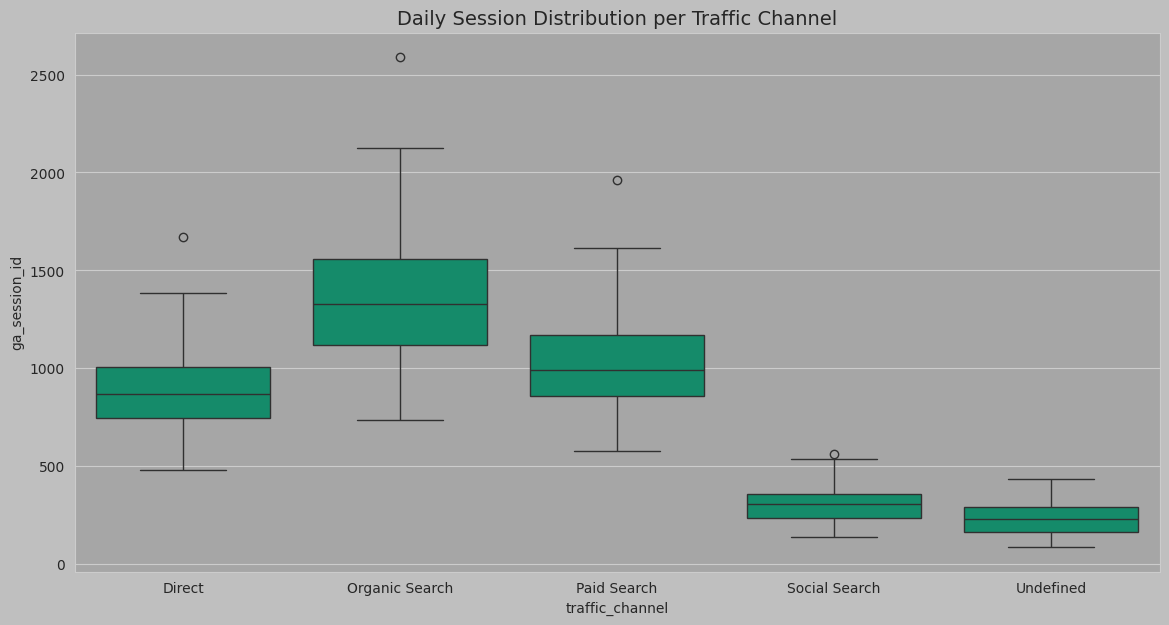

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.set_style("whitegrid")
fig.set_facecolor("#bfbfbf")
ax.set_facecolor("#a6a6a6")

# Boxplot of daily sessions per channel
sns.boxplot(data=sessions_long, x='traffic_channel', y='ga_session_id', color=colors_colorblind[2])
plt.title("Daily Session Distribution per Traffic Channel", fontsize=14, fontweight = "medium")
plt.show()

Before conducting the statistical analysis, I formulated the following hypotheses:

- Null Hypothesis (H0): The distribution of daily sessions across different traffic channels is the same. In other words, there are no statistically significant differences in the number of sessions between the traffic channels.

- Alternative Hypothesis (H1): There are statistically significant differences in the distribution of daily sessions between at least some of the traffic channels.

To investigate whether there are differences in the number of daily sessions across different traffic channels, I conducted several statistical tests.

Normality tests (Shapiro-Wilk) showed that most distributions are not normally distributed, except for Social Search and Undefined.

Therefore, I used the Kruskal-Wallis H-test, a non-parametric alternative to ANOVA. The result was statistically significant (p < 0.0001), indicating that there are differences in session distributions between at least some of the traffic channels.

To identify which pairs of channels differ, I conducted Dunn’s post hoc test with Bonferroni correction. The results revealed multiple significant differences, especially between Organic Search and other channels, as well as Social Search and most others.

These findings suggest that traffic channels vary in performance, and some (like Organic Search or Social Search) show distinct user behavior patterns in terms of session volume. This insight can guide marketing efforts and help optimize resource allocation across channels.

**Testing for differences in the share of organic traffic between Europe and America.**

In [ ]:
# Filter and count unique sessions per day for "Americas and "Europe" continents
americas_sessions_by_organic_search = df[df["continent"] == "Americas"].groupby(["order_date", "continent"])["ga_session_id"].nunique().reset_index()
europe_sessions_by_organic_search = df[df["continent"] == "Europe"].groupby(["order_date", "continent"])["ga_session_id"].nunique().reset_index()

print(f"Americas sessions shape: {americas_sessions_by_organic_search.shape}")
print(f"Europe sessions shape: {europe_sessions_by_organic_search.shape}")

Americas sessions shape: (92, 3)
Europe sessions shape: (92, 3)


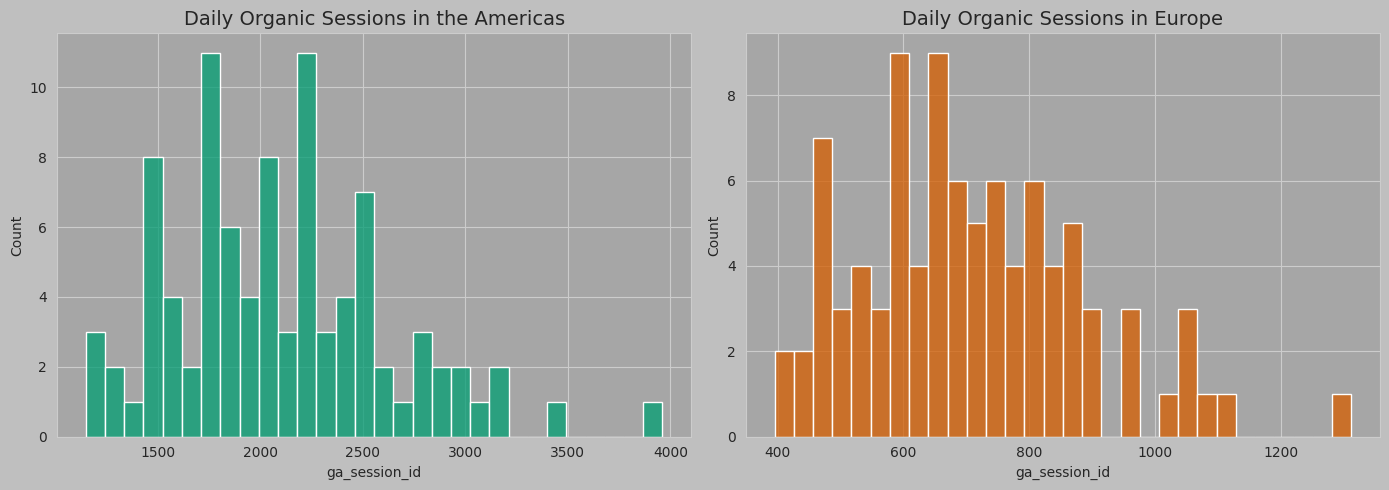

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.set_style("whitegrid")
fig.set_facecolor("#bfbfbf")
for axes in ax.flat:
    axes.set_facecolor("#a6a6a6")

# [0] Plot the histogram of daily sessions for the Americas
sns.histplot(americas_sessions_by_organic_search["ga_session_id"], bins=30, ax=ax[0], color=colors_colorblind[2])
ax[0].set_title("Daily Organic Sessions in the Americas", fontsize=14, fontweight="medium")

# [1] Plot the histogram of daily sessions for Europe
sns.histplot(europe_sessions_by_organic_search["ga_session_id"], bins=30, ax=ax[1], color=colors_colorblind[3])
ax[1].set_title("Daily Organic Sessions in Europe", fontsize=14, fontweight="medium")

plt.tight_layout()
plt.show()

In [ ]:
# Normality test (Shapiro-Wilk) for the share of organic sessions in the Americas and Europe
_, p_value_americas = shapiro(americas_sessions_by_organic_search["ga_session_id"])
_, p_value_europe = shapiro(europe_sessions_by_organic_search["ga_session_id"])

if p_value_americas < 0.05:
    print(f"Americas: p-value = {p_value_americas:.4f} → Distribution is not normal")
else:
    print(f"Americas: p-value = {p_value_americas:.4f} → Distribution is normal")

if p_value_europe < 0.05:
    print(f"Europe: p-value = {p_value_europe:.4f} → Distribution is not normal")
else:
    print(f"Europe: p-value = {p_value_europe:.4f} → Distribution is normal")

Americas: p-value = 0.0365 → Distribution is not normal
Europe: p-value = 0.0321 → Distribution is not normal


In [ ]:
# Perform the Mann-Whitney U test to check for a statistically significant difference between the two groups

u_stat, p_value = mannwhitneyu(americas_sessions_by_organic_search["ga_session_id"], europe_sessions_by_organic_search["ga_session_id"])

if p_value < 0.05:
    print(f"Mann-Whitney U test: p-value = {p_value:.4f} → There is a statistically significant difference between the two groups")
else:
    print(f"Mann-Whitney U test: p-value = {p_value:.4f} → There is no statistically significant difference between the two groups")

Mann-Whitney U test: p-value = 0.0000 → There is a statistically significant difference between the two groups


Hypotheses:
- Null Hypothesis (H0): There is no difference in the distributions of daily organic sessions between the Americas and Europe.

- Alternative Hypothesis (H1): There is a difference in the distributions of daily organic sessions between the Americas and Europe.

Conclusion:
- Normality Test (Shapiro-Wilk):
For both groups (Americas and Europe), the p-value is less than 0.05 (p = 0.0365 for the Americas and p = 0.0321 for Europe), indicating that the distributions are not normal.

- Mann-Whitney U Test:
After confirming that the data is not normal, a non-parametric Mann-Whitney U test was performed. The p-value of the test (p = 0.0000) is less than 0.05, which allows us to reject the null hypothesis.

There is a statistically significant difference in the distributions of daily organic sessions between the Americas and Europe. This means that the organic sessions in these two regions are not the same, and we can conclude that there are some differences in the behavior of organic traffic users between the two continents.

**Testing for a statistically significant difference in average sales price between different continents.**

In [ ]:
# Checking unique continents
df["continent"].unique()

array(['Americas', 'Europe', 'Africa', 'Asia', 'Oceania', '(not set)'],
      dtype=object)

In [ ]:
# Grouping by date and continent, calculating average price
daily_sales_by_continents = df.groupby(['order_date', 'continent'])['price'].mean().reset_index()

# Creating a pivot table: dates as rows, continents as columns
pivot_sales = daily_sales_by_continents.pivot_table(index='order_date', columns='continent', values='price')

# Filling missing values with 0
pivot_sales = pivot_sales.fillna(0)

In [ ]:
# Counting number of unique days per continents
sample_sizes_pivot_sales = daily_sales_by_continents.groupby('continent')['order_date'].nunique()

sample_sizes_pivot_sales

,order_date
continent,
(not set),92
Africa,92
Americas,92
Asia,92
Europe,92
Oceania,92


In [ ]:
# Shapiro-Wilk test for normality
for column in pivot_sales.columns:
    stat, p = shapiro(pivot_sales[column])
    print(f"{column}: p-value = {p:.4f} → {'Not normal' if p < 0.05 else 'Normal'}")

(not set): p-value = 0.0000 → Not normal
Africa: p-value = 0.0000 → Not normal
Americas: p-value = 0.9277 → Normal
Asia: p-value = 0.0139 → Not normal
Europe: p-value = 0.3465 → Normal
Oceania: p-value = 0.0000 → Not normal


In [ ]:
# Preparing data as separate lists per channel for Kruskal-Wallis test
group_values_pivot_sales = [pivot_sales[col] for col in pivot_sales.columns]

# Kruskal-Wallis H-test for independent samples (non-parametric alternative to ANOVA)
stat, p_value = kruskal(*group_values)

if p_value < 0.05:
    print(f"Kruskal-Wallis test: p-value = {p_value:.4f} → Statistically significant differences between groups")
else:
    print(f"Kruskal-Wallis test: p-value = {p_value:.4f} → No statistically significant differences between groups")

Kruskal-Wallis test: p-value = 0.0000 → Statistically significant differences between groups


In [ ]:
# Resetting index to allow melting from wide to long format
pivot_sales = pivot_sales.reset_index()

In [ ]:
# Melting data into long format for posthoc testing
sales_long = pivot_sales.melt(id_vars='order_date', var_name='continent', value_name='price')

# Post hoc Dunn's test with Bonferroni correction
posthoc_sales_long = sp.posthoc_dunn(sales_long, val_col='price', group_col='continent', p_adjust='bonferroni')

print(posthoc_sales_long.to_string())

              (not set)    Africa      Americas          Asia        Europe   Oceania
(not set)  1.000000e+00  0.000007  4.188185e-14  3.993516e-14  9.541637e-14  0.000005
Africa     6.861452e-06  1.000000  6.425037e-02  6.306020e-02  8.851987e-02  1.000000
Americas   4.188185e-14  0.064250  1.000000e+00  1.000000e+00  1.000000e+00  0.079964
Asia       3.993516e-14  0.063060  1.000000e+00  1.000000e+00  1.000000e+00  0.078513
Europe     9.541637e-14  0.088520  1.000000e+00  1.000000e+00  1.000000e+00  0.109435
Oceania    4.742753e-06  1.000000  7.996383e-02  7.851277e-02  1.094353e-01  1.000000


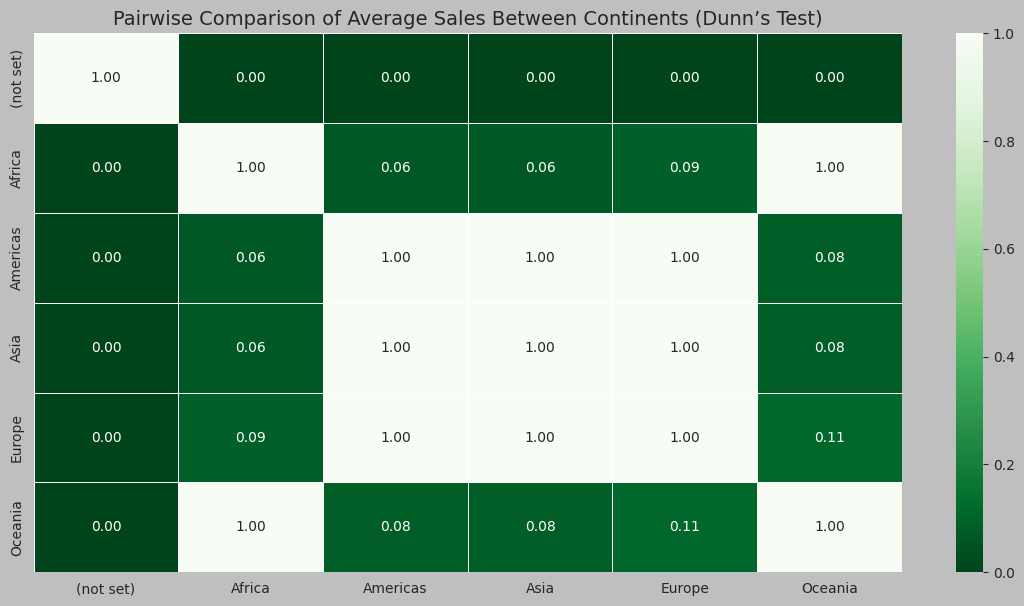

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.set_style("whitegrid")
fig.set_facecolor("#bfbfbf")

# Heatmap of p-values from Dunn's test
sns.heatmap(data=posthoc_sales_long, cmap="Greens_r", annot=True, fmt=".2f", linewidths=0.5)

plt.title("Pairwise Comparison of Average Sales Between Continents (Dunn’s Test)", fontsize=14, fontweight = "medium")
plt.show()

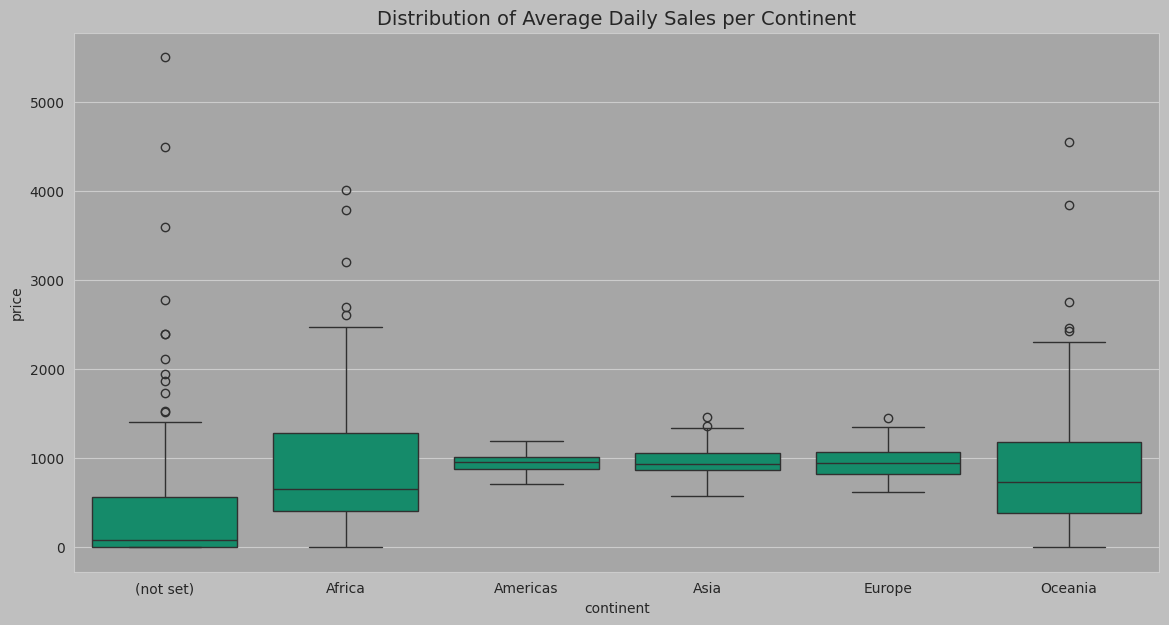

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

sns.set_style("whitegrid")
fig.set_facecolor("#bfbfbf")
ax.set_facecolor("#a6a6a6")

# Boxplot of average daily sales per continent
sns.boxplot(data=sales_long, x='continent', y='price', color=colors_colorblind[2])
plt.title("Distribution of Average Daily Sales per Continent", fontsize=14, fontweight = "medium")
plt.show()

Hypotheses:
- Null Hypothesis (H0): There is no statistically significant difference in mean daily sales between continents.

- Alternative Hypothesis (H1): There is a statistically significant difference in mean daily sales between at least two continents.

Conclusion:
Shapiro-Wilk test showed that the data is not normally distributed for most continents (p < 0.05 in nearly all cases, except for Americas and Europe).
Therefore, the non-parametric Kruskal-Wallis test was chosen for hypothesis testing.

Kruskal-Wallis test returned a p-value = 0.0000, which is significantly less than 0.05.
This indicates that there are statistically significant differences in mean sales between continents.

Post-hoc Dunn’s test with Bonferroni correction revealed that:

Statistically significant differences exist only between the (not set) group and all other continents (p < 0.0001).

For all other continent pairs (e.g., Europe vs Americas, Asia vs Africa), no statistically significant differences were found (p > 0.05).

According to the test results, there are no statistically significant differences in mean daily sales between continents.
Significant differences exist only between the (not set) group and the other continents. All other continent pairs (e.g., Americas–Europe, Asia–Africa) show no substantial differences in average sales levels.

## Conclusion of Sales Analysis

**Link to the** **[dashboard](https://public.tableau.com/views/E-commerceSalesDashboard_17455059055270/Dashboard1?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)**

#### **General Conclusions:**

The analysis of the three-month sales data (from 2020-11-01 to 2021-01-31) across 349,545 sessions reveals several key insights. The Americas are the dominant market, generating the highest sales and unit volume. The United States leads significantly, with India and Canada as the next most important markets, albeit with considerably lower figures. In contrast, Africa and Oceania demonstrate modest sales.

Product performance varies: "Sofas & armchairs" drive the highest revenue, while "Bookcases & shelving units" lead in units sold. This discrepancy, with bookcases showing high demand but lower sales volume, presents an opportunity for optimization. "Chairs" and "Beds" show consistent performance.

Search engines (Organic and Paid) are the primary traffic channels, driving the majority of sales. Direct traffic is also a significant contributor, indicating customer loyalty. While mobile devices account for approximately 39% of purchases, desktop remains the dominant platform at around 60%.

Email engagement is strong: approximately 71.70% of users have verified their email addresses, and 83.06% are subscribed. Subscribed users generate substantially higher total revenue (≈  2,150,796.99vs.≈ 431,721.60 for unsubscribed), despite a slightly lower average purchase price (≈  921.51vs.≈ 965.82).

Sales exhibit a clear weekly pattern, peaking mid-week (Tuesdays and Wednesdays, with sales around  5,460,000)anddecliningonweekends(salesaround 3,470,000). There's also a seasonal influence, with a notable increase leading up to mid-December.

Statistical analysis confirms a strong positive correlation (Pearson correlation coefficient of 0.79) between sessions and sales. It also highlights significant differences in sales between registered and unregistered users (p < 0.0001), in the distribution of sessions across traffic channels (Kruskal-Wallis p < 0.0001), and in organic traffic share between the Americas and Europe (Mann-Whitney U p = 0.0000).

#### **Business Recommendations:**

1. **Optimize Market Strategy:**
 Prioritize the Americas, especially the United States, given their high sales volume.
Develop strategies to increase market share in Asia and Europe.
Evaluate the potential for growth in Africa and Oceania, or consider focused niche strategies.

2. **Optimize Product Strategy:**
Resolve the gap between high "Bookcases & shelving units" unit sales and their contribution to overall sales value.
Explore bundling with related items (e.g., decor, lighting), upselling to higher-priced options, or introducing premium versions to better monetize this high-demand category.

3. **Enhance Mobile Conversion:**
Analyze the user journey of mobile users, especially those arriving from search and social media, to identify and address potential friction points in the mobile checkout process. A/B test different mobile interface elements to improve conversion rates.

4. **Nurture Subscriptions:**
 Continue to prioritize email subscription growth and retention strategies. Explore personalized offers and content for subscribers to encourage repeat purchases and increase their overall contribution to revenue.

5. **Optimize Marketing Spend by Channel:**
Maintain strong SEO and SEM efforts given their dominance in driving sales. Investigate the "undefined" traffic source to understand its origin and potential for optimization. Re-evaluate the effectiveness of social media marketing.

6. **Leverage Weekly Sales Patterns:**
Tailor marketing campaigns, promotions, and inventory management based on the observed weekly sales cycle. Consider running targeted promotions during peak days (Tuesday and Wednesday) and exploring strategies to boost weekend sales.

7. **Investigate Correlated Sales:**
Explore product recommendation and cross-selling opportunities based on the identified correlations between product categories. For instance, suggest rugs or lamps to customers purchasing sofas or armchairs.

8. **Personalize User Experience:**
Given the significant difference in sales between registered and unregistered users, encourage user registration by highlighting benefits such as exclusive offers, personalized recommendations, and easier checkout.

9. **Further Investigate Continental Differences:**
While average sales prices are similar across most continents, the difference in organic traffic share between the Americas and Europe warrants further investigation into user behavior and search patterns in these regions to optimize organic acquisition strategies.

10. **Investigate and Fix 'not set' Category:**
Resolve the "not set" attribution issue for accurate reporting and decision-making.
